# #WaveSight

In [1]:
%load_ext autoreload
%autoreload 2
import wavesight as ws
import sympy as sp
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import fsolve, root_scalar
import cmasher as cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
%config InlineBackend.figure_format='retina'
import warnings
print("Warning disabling RuntimeWarning often due to evalution of square roots with negative arguments.\nProbably produced by scalar_root.")
warnings.filterwarnings("ignore", category=RuntimeWarning)
import pickle
from matplotlib.patches import Circle
import matplotlib.ticker as ticker


Warning disabling RuntimeWarning often due to evalution of square roots with negative arguments.
Probably produced by scalar_root.


## ##Step-index cylindrical waveguide

### ###The trascendental equation for kz

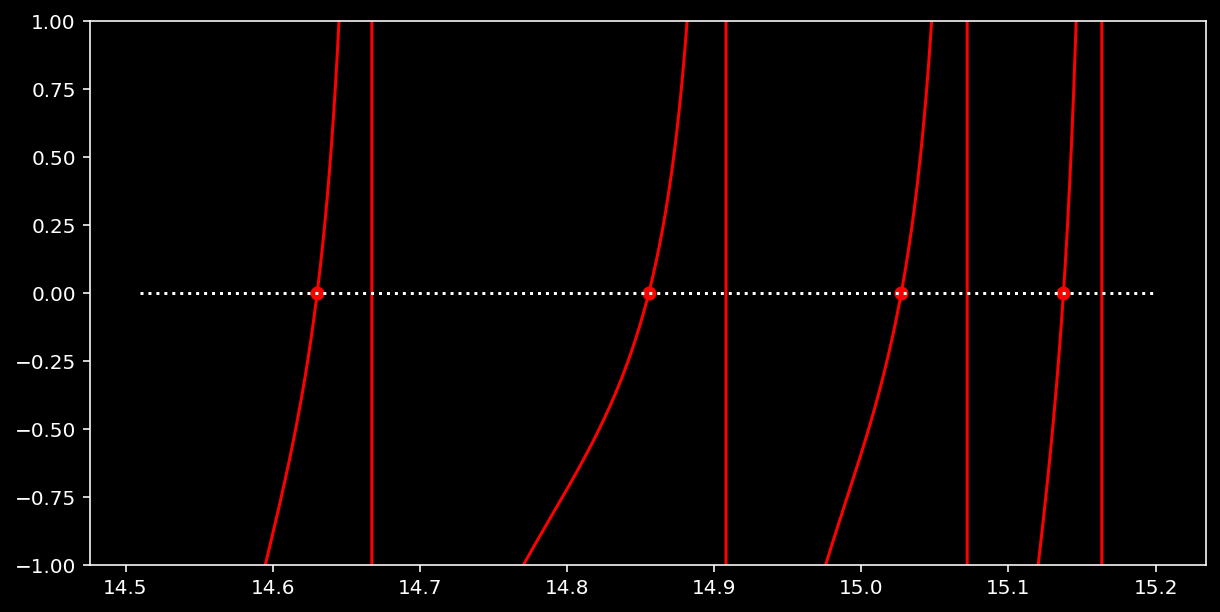

In [3]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
tmfun = ws.tmfungen(λfree=wavelength, 
                 n2=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
kzmax = 1.001*nCore*2*np.pi/wavelength
kzmin = 0.999*nCladding*2*np.pi/wavelength
kzrange = np.linspace(kzmin, kzmax, 1000)
tmvals = tmfun(kzrange)
tmzeros = ws.findallroots(tmfun, kzmin, kzmax, 0.01, dtype=ws.real_dtype, method='bisect', num_sigfigs=6, verbose=False)
tmzerocheck = tmfun(tmzeros)
plt.figure(figsize=(10,5))
plt.plot(kzrange, tmvals, 'r')
plt.scatter(tmzeros,tmzerocheck, c='r')
plt.plot([kzmin, kzmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()

### ###ws.multisolver

Solve the propagation constants of a fiber of the given geometry 
and plot the axial field together with density plots for the tangential
field.

Calculate a numerical basis using the calculated modes.

In [4]:
fiber_spec = {'NA': 0.39,
              'nCore': 1.45,
              'coreRadius':3.,
              'free_space_wavelength': 0.600}
fiber_sol = ws.multisolver(fiber_spec, drawPlots=False, verbose=True)

Approx number of complex HE modes:  31
Approx number of TE modes:  6
Approx number of TM modes:  6
Approx number of total modes:  75
Approx Max n for HE modes:  7
Calculting TE(0,n) propagation constants ...
Calculting TM(0,n) propagation constants ...
Calculting HE(m,n) propagation constants ...
m=10
HE modes = 68
TE modes = 8
TM modes = 8
TOTAL modes = 84
FROM_Vnum = 75


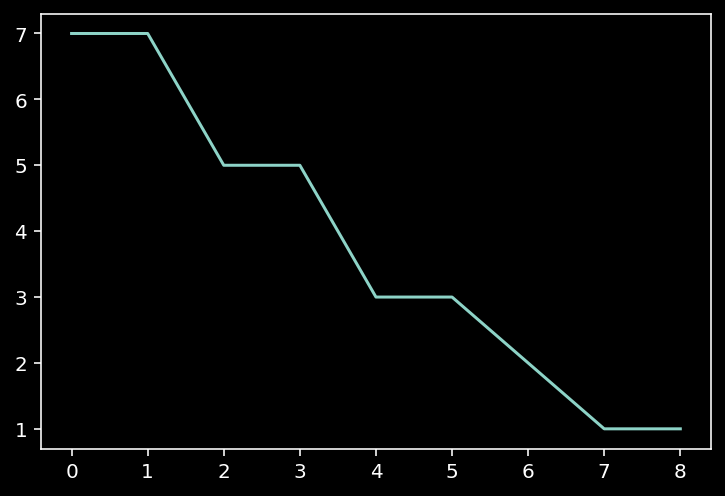

In [5]:
TEcounter = list(map(len,fiber_sol['HEkz'].values()))
plt.figure()
plt.plot(TEcounter)
plt.show()

#### ####HE modes

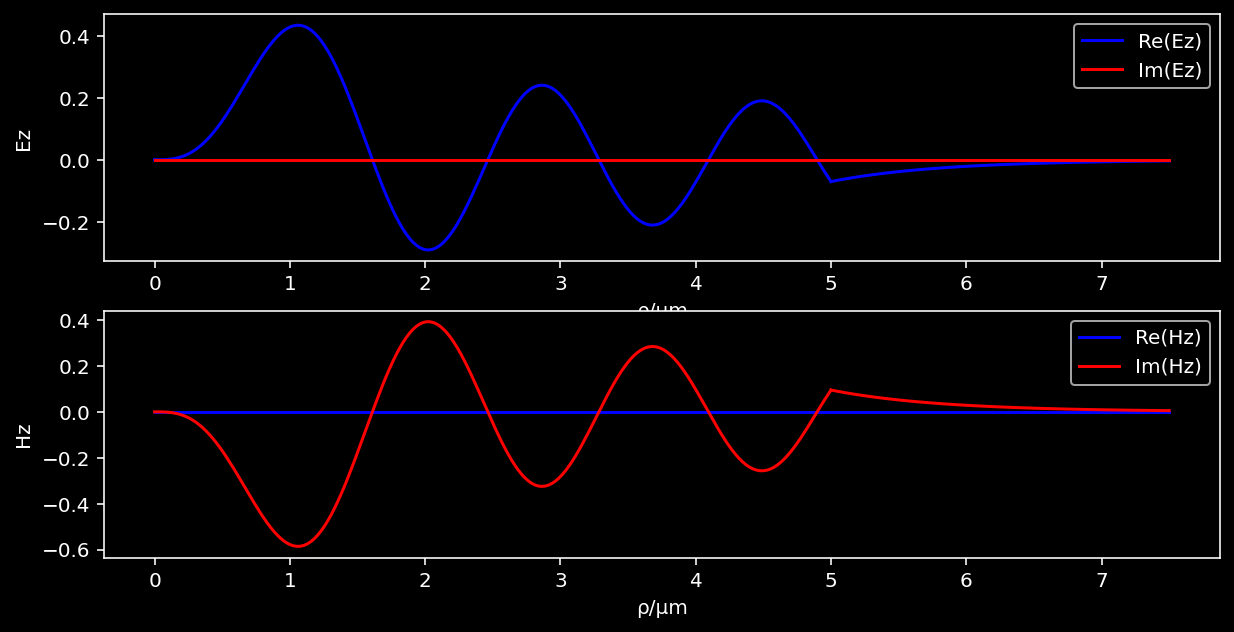

In [ ]:
a = fiber_sol['coreRadius']
b = a*1.5 # assumed, in reality the cladding is assumed to be infinite
nCore = fiber_sol['nCore']
nCladding = fiber_sol['nCladding']

# given a value for m, plot the axial and transverse fields
m = 3
kz = fiber_sol['HEkz'][m][0]
λfree = fiber_sol['free_space_wavelength']
γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)

Ae, Ah, Be, Bh = ws.AeAhBeBh("HE", a, nCore, nCladding, λfree, m, kz)

Ez_1 = ws.Ezgen_1(Ae, m, γ)
Ez_2 = ws.Ezgen_2(Be, m, β)
Hz_1 = ws.Hzgen_1(Ah, m, γ)
Hz_2 = ws.Hzgen_2(Bh, m, β)

Et1 = ws.Et1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
Et2 = ws.Et2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
Ht1 = ws.Ht1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCore)
Ht2 = ws.Ht2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCladding)

ρrangein = np.linspace(0, a, 200)
ρrangeout = np.linspace(a, b, 50)

Ezvals1 = Ez_1(ρrangein)
Ezvals2 = Ez_2(ρrangeout)
Hzvals1 = Hz_1(ρrangein)
Hzvals2 = Hz_2(ρrangeout)

fig, ax = plt.subplots(nrows=2,figsize=(10,5))
ax[0].plot(ρrangein, np.real(Ezvals1), 'b', label='Re(Ez)')
ax[0].plot(ρrangeout, np.real(Ezvals2), 'b')
ax[0].plot(ρrangein, np.imag(Ezvals1), 'r', label='Im(Ez)')
ax[0].plot(ρrangeout, np.imag(Ezvals2), 'r')
ax[0].set_xlabel('ρ/µm')
ax[0].set_ylabel('Ez')
ax[0].legend()
ax[1].plot(ρrangein, np.real(Hzvals1),'b', label='Re(Hz)')
ax[1].plot(ρrangeout, np.real(Hzvals2),'b')
ax[1].plot(ρrangein, np.imag(Hzvals1),'r', label='Im(Hz)')
ax[1].plot(ρrangeout, np.imag(Hzvals2),'r')
ax[1].set_xlabel('ρ/µm')
ax[1].set_ylabel('Hz')
ax[1].legend()
plt.subplots_adjust()
plt.show()

In [ ]:
xrange = np.linspace(-b, b, 200)
yrange = np.linspace(-b, b, 200)
X, Y = np.meshgrid(xrange, yrange)
Etvals1 = Et1(X, Y)
Etvals2 = Et2(X, Y)
Htvals1 = Ht1(X, Y)
Htvals2 = Ht2(X, Y)

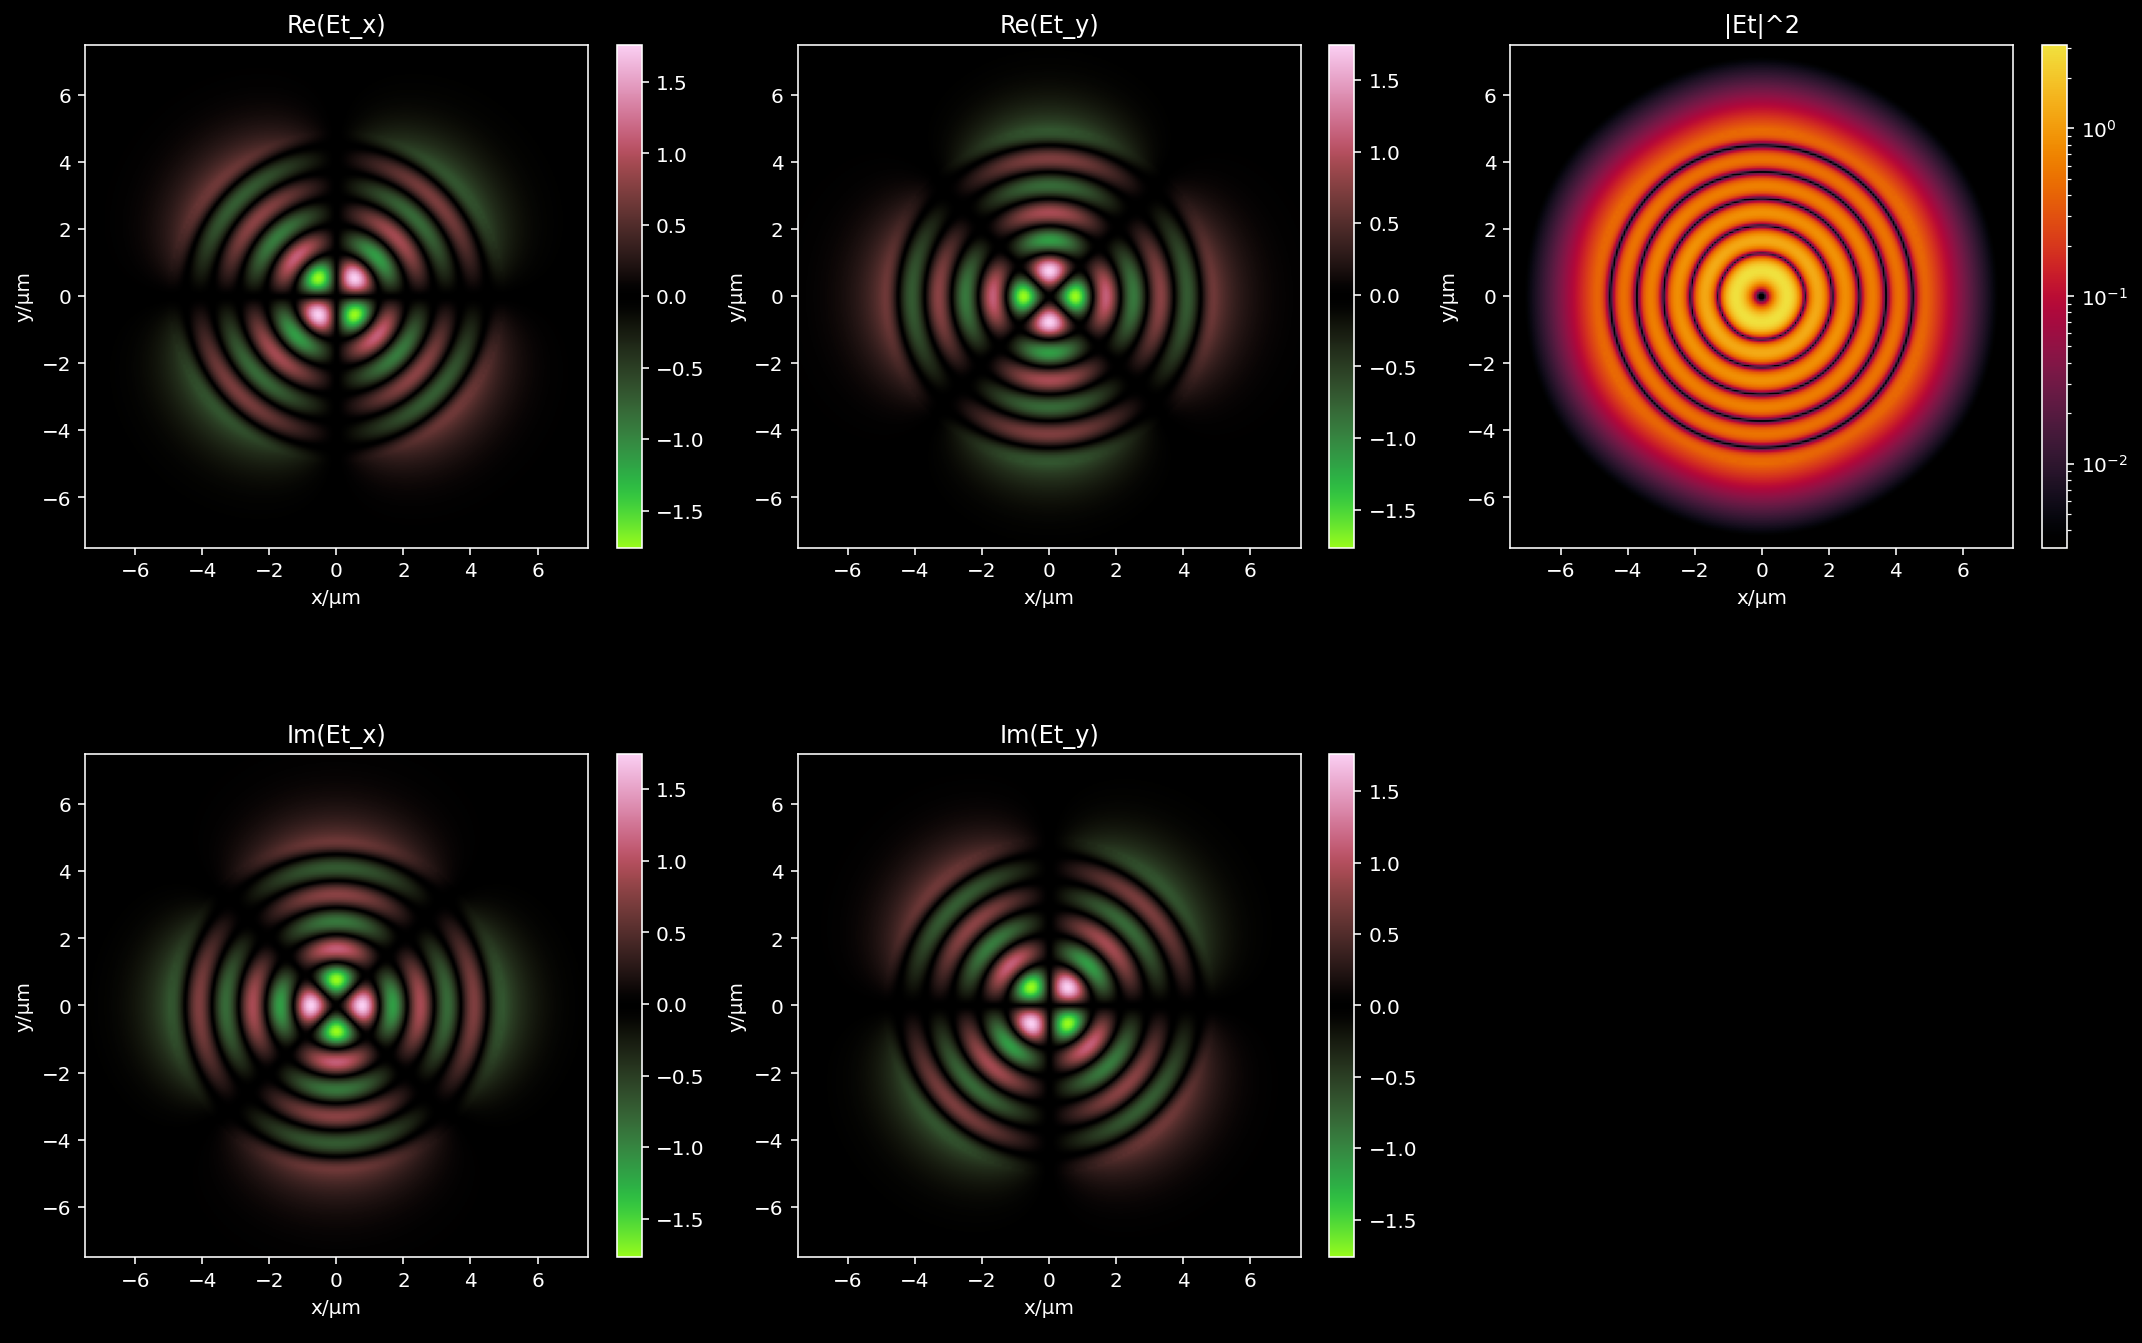

In [ ]:
fieldarray1 = np.real(Etvals1[0,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.real(Etvals2[0,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_x = fieldarray1 + fieldarray2

fieldarray1 = np.real(Etvals1[1,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.real(Etvals2[1,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_y = fieldarray1 + fieldarray2

fieldarray1 = np.real(Etvals1[0,:,])**2 + np.real(Etvals1[1,:,])**2
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.real(Etvals2[0,:,])**2 + np.real(Etvals2[1,:,])**2
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_mag2 = fieldarray1 + fieldarray2

fieldarray1 = np.imag(Etvals1[0,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.imag(Etvals2[0,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_xim = fieldarray1 + fieldarray2

fieldarray1 = np.imag(Etvals1[1,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.imag(Etvals2[1,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_yim = fieldarray1 + fieldarray2

plotfields = [fieldarray_x, fieldarray_y, fieldarray_mag2, fieldarray_xim, fieldarray_yim]

labels = ['Re(Et_x)', 'Re(Et_y)', '|Et|^2', 'Im(Et_x)', 'Im(Et_y)']

fig, axes = plt.subplots(nrows = 2, ncols=3, figsize=(15,10))

for idx, (pfield, label) in enumerate(zip(plotfields, labels)):
    ax = axes[idx//3, idx%3]
    if label == '|Et|^2':
        cmap = cm.ember
        maxmag2 = np.max(fieldarray_mag2)
        iplot = ax.imshow(fieldarray_mag2, 
                norm=LogNorm(vmin=maxmag2*1e-3, vmax=maxmag2),
                cmap=cmap, 
                extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
    else:
        cmap = cm.watermelon
        iplot = ax.imshow(pfield, 
            cmap=cmap, 
            extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
    ax.set_title(label)
    ax.set_xlabel('x/µm')
    ax.set_ylabel('y/µm')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(iplot, cax=cax)

axes[1,2].set_axis_off()

plt.tight_layout()
plt.show()

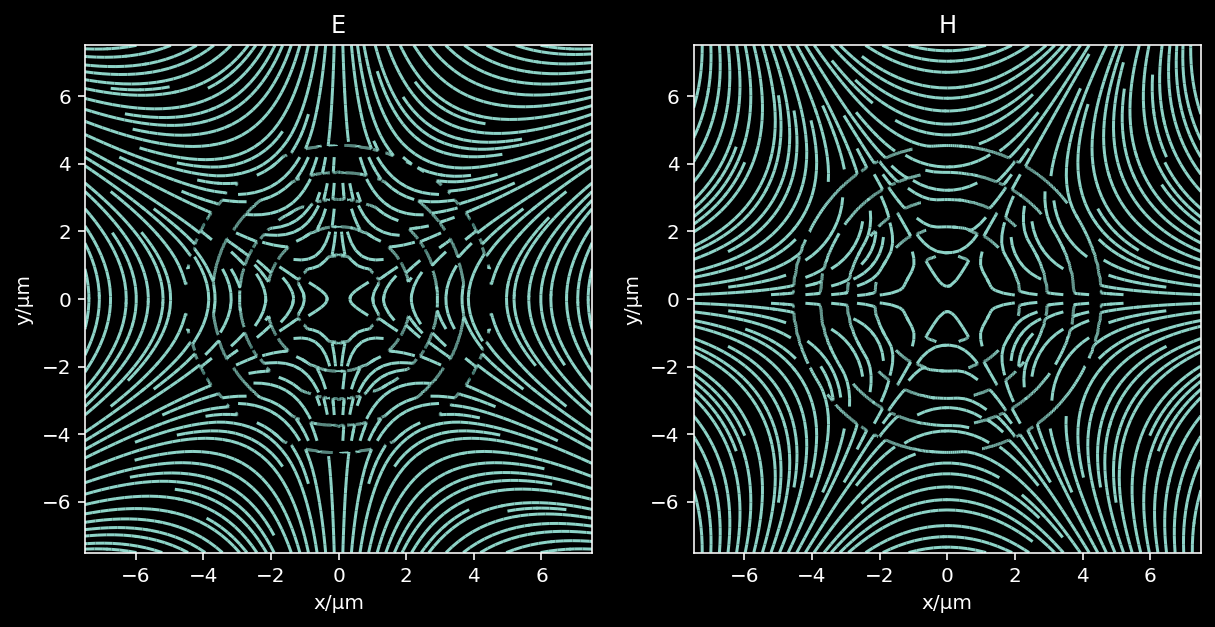

In [ ]:
Ex1 = np.real(Etvals1[0,:,:])
Ex1[X**2 + Y**2 > a**2] = 0
Ex2 = np.real(Etvals2[0,:,:])
Ex2[X**2 + Y**2 < a**2] = 0
Ex = Ex1 + Ex2
Ey1 = np.real(Etvals1[1,:,:])
Ey1[X**2 + Y**2 > a**2] = 0
Ey2 = np.real(Etvals2[1,:,:])
Ey2[X**2 + Y**2 < a**2] = 0
Ey = Ey1 + Ey2

Hx1 = np.real(Htvals1[0,:,:])
Hx1[X**2 + Y**2 > a**2] = 0
Hx2 = np.real(Htvals2[0,:,:])
Hx2[X**2 + Y**2 < a**2] = 0
Hx = Hx1 + Hx2
Hy1 = np.real(Htvals1[1,:,:])
Hy1[X**2 + Y**2 > a**2] = 0
Hy2 = np.real(Htvals2[1,:,:])
Hy2[X**2 + Y**2 < a**2] = 0
Hy = Hy1 + Hy2

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].streamplot(xrange, yrange, Ex, Ey, arrowstyle='-', density=2)
axes[0].set_xlabel('x/µm')
axes[0].set_ylabel('y/µm')
axes[0].set_title('E')
axes[0].set_aspect('equal')

axes[1].streamplot(xrange, yrange, Hx, Hy, arrowstyle='-', density=2)
axes[1].set_xlabel('x/µm')
axes[1].set_ylabel('y/µm')
axes[1].set_title('H')
axes[1].set_aspect('equal')
plt.show()

#### ####TM and TE modes

In [ ]:
# def AeTE(a, n1, n2, λfree, kz):
#     return 1

# def AhTE(a, n1, n2, λfree, kz):
#     return 0

# def BeTE(a, n1, n2, λfree, kz):
#     return special.jv(0, a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2))/special.kn(0,a*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2))

# def BhTE(a, n1, n2, λfree, kz):
#     return 0

# def AeTM(a, n1, n2, λfree, kz):
#     return 0

# def AhTM(a, n1, n2, λfree, kz):
#     return 1

# def BeTM(a, n1, n2, λfree, kz):
#     return 0

# def BhTM(a, n1, n2, λfree, kz):
#     return -((np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2)*special.jv(1,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)))/(np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)*special.kn(1,a*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2))))



# def AeAhBeBhTM(a, n1, n2, λfree, kz):
#     return (AeTM(a, n1, n2, λfree, kz),
#             AhTM(a, n1, n2, λfree, kz),
#             BeTM(a, n1, n2, λfree, kz),
#             BhTM(a, n1, n2, λfree, kz))

# def AeAhBeBhTE(a, n1, n2, λfree, kz):
#     return (AeTE(a, n1, n2, λfree, kz),
#             AhTE(a, n1, n2, λfree, kz),
#             BeTE(a, n1, n2, λfree, kz),
#             BhTE(a, n1, n2, λfree, kz))

1 0 -193136.647044981 0.0


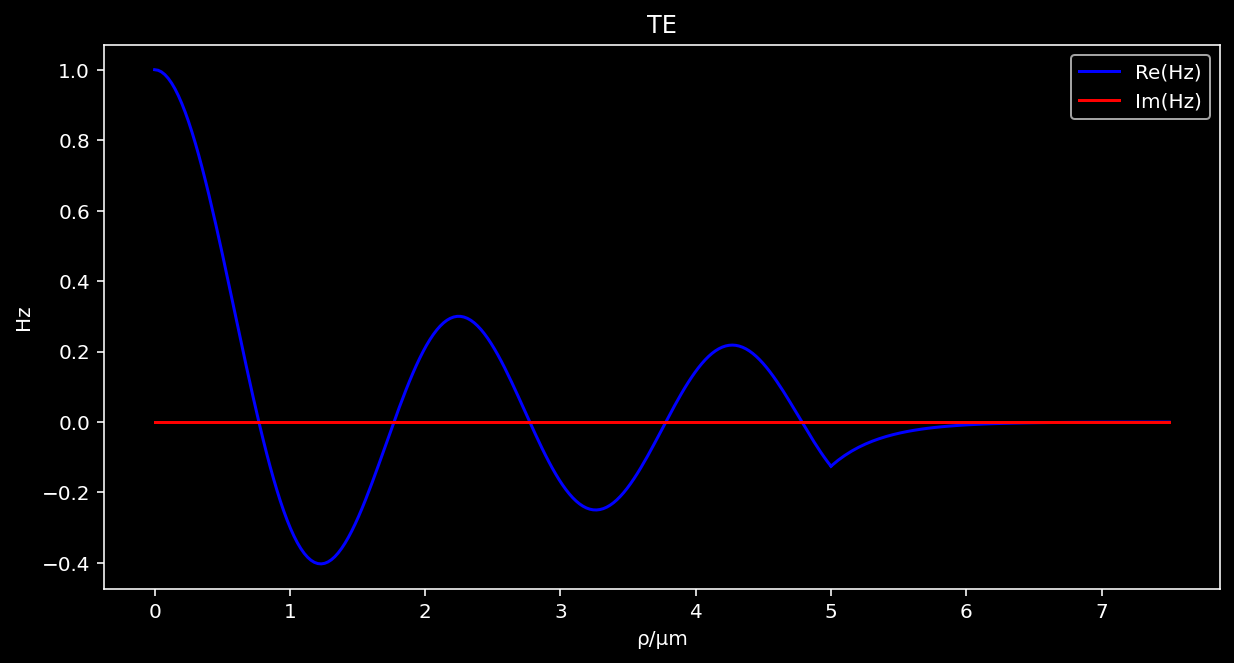

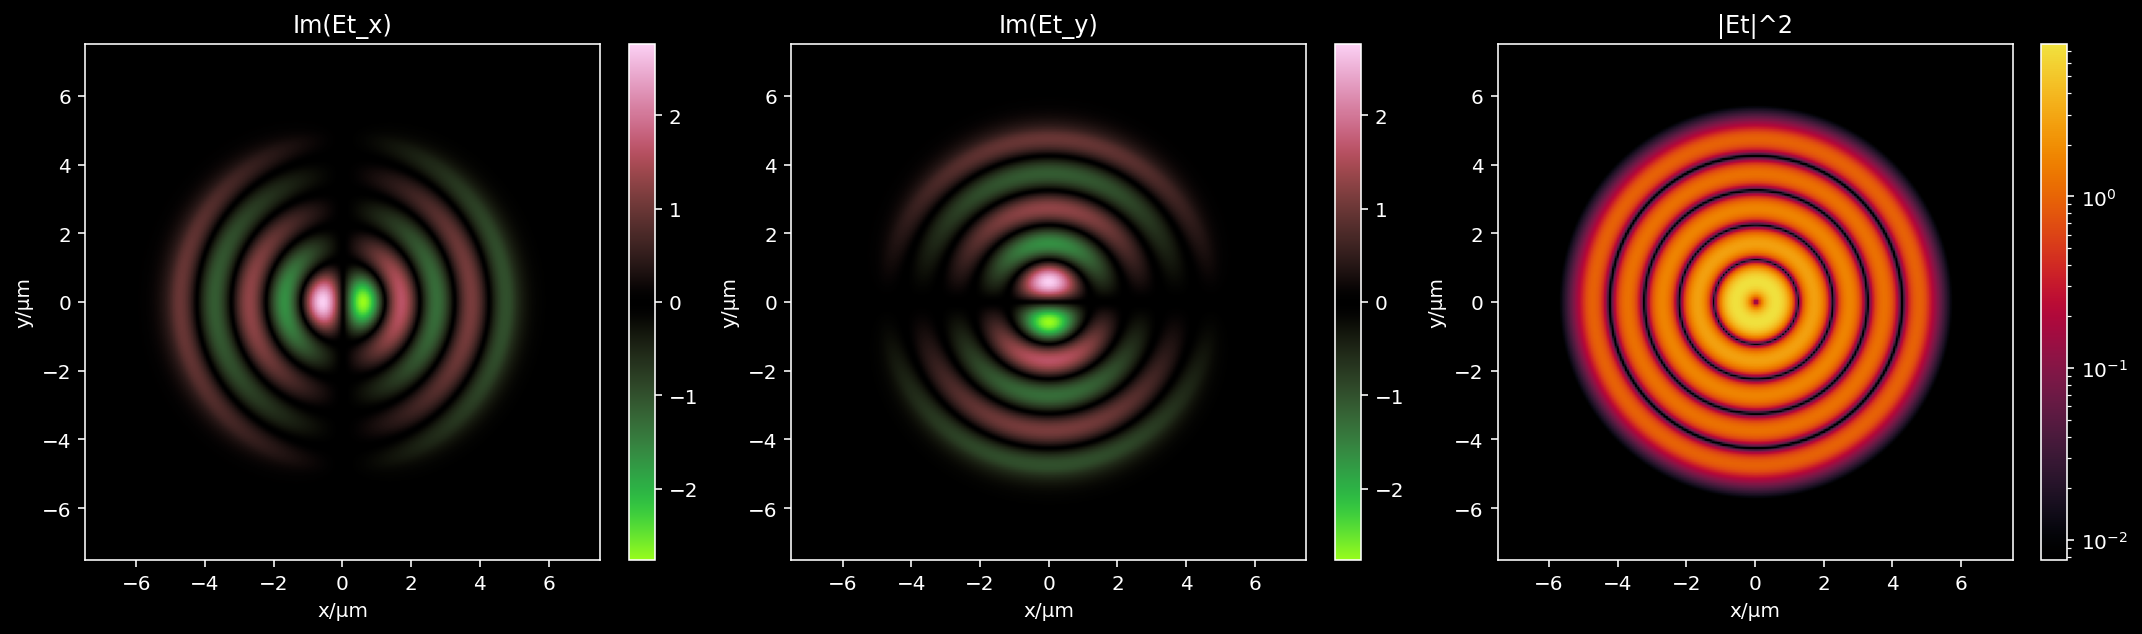

0 1 0 -193397.18468008417


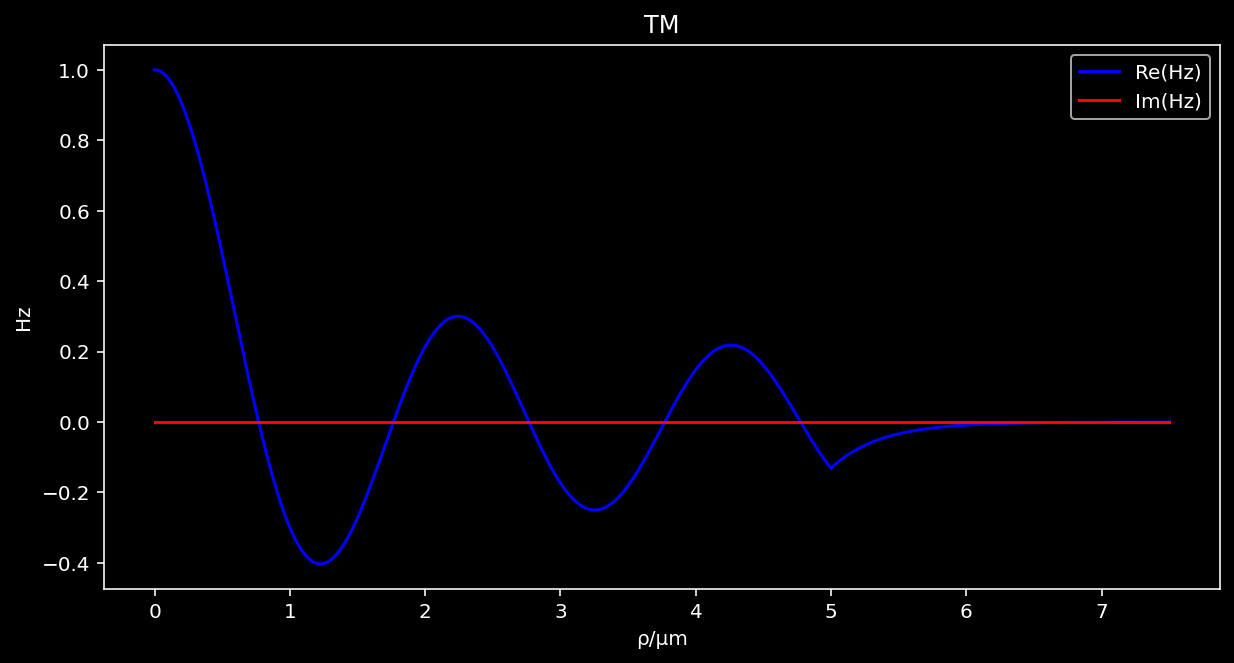

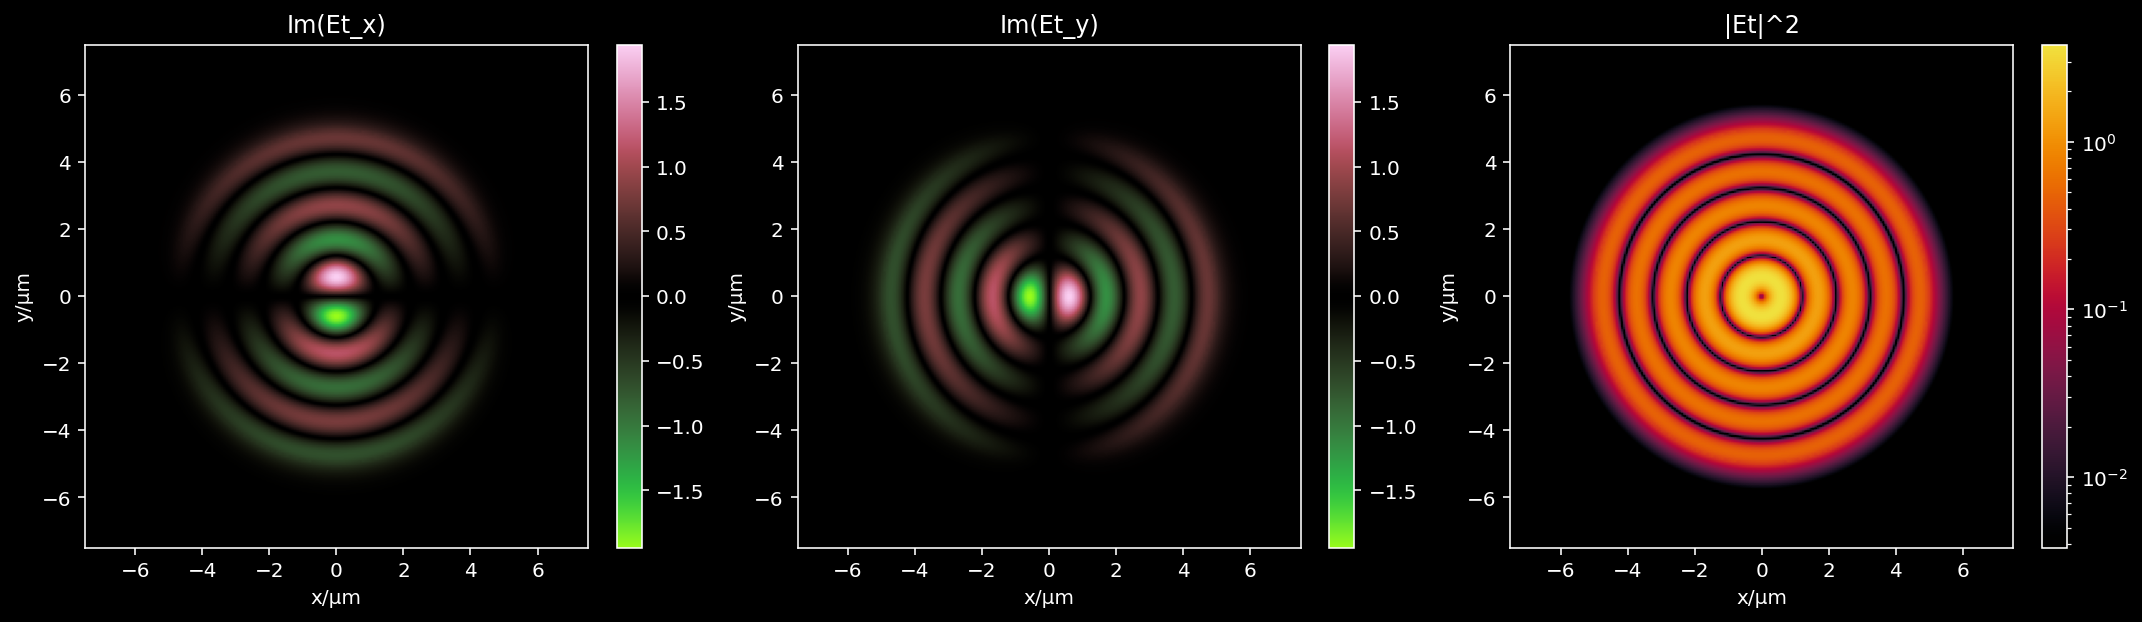

In [ ]:
a = fiber_sol['coreRadius']
b = a*1.5 # assumed, in reality the cladding is assumed to be infinite
nCore = fiber_sol['nCore']
nCladding = fiber_sol['nCladding']

# given a value for plot the axial and transverse fields
m = 0
n = 2
λfree = fiber_sol['free_space_wavelength']

xrange = np.linspace(-b, b, 200)
yrange = np.linspace(-b, b, 200)
X, Y = np.meshgrid(xrange, yrange)

for modtype in ["TE","TM"]:
    Ae, Ah, Be, Bh = ws.AeAhBeBh(modtype, a, nCore, nCladding, λfree, m, kz)
    kz = fiber_sol['%skz' % modtype][m][n]
    γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
    β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)
    print(Ae, Ah, Be, Bh)

    Ez_1 = ws.Ezgen_1(Ae, m, γ)
    Ez_2 = ws.Ezgen_2(Be, m, β)
    Hz_1 = ws.Hzgen_1(Ah, m, γ)
    Hz_2 = ws.Hzgen_2(Bh, m, β)

    Et1 = ws.Et1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
    Et2 = ws.Et2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
    Ht1 = ws.Ht1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCore)
    Ht2 = ws.Ht2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCladding)

    ρrangein = np.linspace(0, a, 200)
    ρrangeout = np.linspace(a, b, 50)

    Ezvals1 = Ez_1(ρrangein)
    Ezvals2 = Ez_2(ρrangeout)
    Hzvals1 = Hz_1(ρrangein)
    Hzvals2 = Hz_2(ρrangeout)

    fig, ax = plt.subplots(nrows=1,figsize=(10,5))
    if modtype == "TM":
        ax.plot(ρrangein, np.real(Hzvals1),'b', label='Re(Hz)')
        ax.plot(ρrangeout, np.real(Hzvals2),'b')
        ax.plot(ρrangein, np.imag(Hzvals1),'r', label='Im(Hz)')
        ax.plot(ρrangeout, np.imag(Hzvals2),'r')
    else:
        ax.plot(ρrangein, np.real(Ezvals1),'b', label='Re(Hz)')
        ax.plot(ρrangeout, np.real(Ezvals2),'b')
        ax.plot(ρrangein, np.imag(Ezvals1),'r', label='Im(Hz)')
        ax.plot(ρrangeout, np.imag(Ezvals2),'r')
    ax.set_xlabel('ρ/µm')
    ax.set_ylabel('Hz')
    ax.set_title(modtype)
    ax.legend()
    plt.subplots_adjust()
    plt.show()

    Etvals1 = Et1(X, Y)
    Etvals2 = Et2(X, Y)
    Htvals1 = Ht1(X, Y)
    Htvals2 = Ht2(X, Y)

    fieldarray1 = np.imag(Etvals1[0,:,])
    fieldarray1[X**2 + Y**2 > a**2] = 0
    fieldarray2 = np.imag(Etvals2[0,:,])
    fieldarray2[X**2 + Y**2 < a**2] = 0
    fieldarray_xim = fieldarray1 + fieldarray2

    fieldarray1 = np.imag(Etvals1[1,:,])
    fieldarray1[X**2 + Y**2 > a**2] = 0
    fieldarray2 = np.imag(Etvals2[1,:,])
    fieldarray2[X**2 + Y**2 < a**2] = 0
    fieldarray_yim = fieldarray1 + fieldarray2

    fieldarray1 = np.imag(Etvals1[0,:,])**2 + np.imag(Etvals1[1,:,])**2
    fieldarray1[X**2 + Y**2 > a**2] = 0
    fieldarray2 = np.imag(Etvals2[0,:,])**2 + np.imag(Etvals2[1,:,])**2
    fieldarray2[X**2 + Y**2 < a**2] = 0
    fieldarray_mag2 = fieldarray1 + fieldarray2

    plotfields = [fieldarray_xim, fieldarray_yim, fieldarray_mag2]

    labels = ['Im(Et_x)', 'Im(Et_y)', '|Et|^2']

    fig, axes = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))

    for idx, (pfield, label) in enumerate(zip(plotfields, labels)):
        ax = axes[idx]
        if label == '|Et|^2':
            cmap = cm.ember
            maxmag2 = np.max(fieldarray_mag2)
            iplot = ax.imshow(fieldarray_mag2, 
                    norm=LogNorm(vmin=maxmag2*1e-3, vmax=maxmag2),
                    cmap=cmap, 
                    extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
        else:
            cmap = cm.watermelon
            iplot = ax.imshow(pfield, 
                cmap=cmap, 
                extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
        ax.set_title(label)
        ax.set_xlabel('x/µm')
        ax.set_ylabel('y/µm')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        plt.colorbar(iplot, cax=cax)
    plt.tight_layout()
    plt.show()

In [ ]:
# fieldarray1 = np.imag(Etvals1[0,:,])
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[0,:,])
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_xim = fieldarray1 + fieldarray2

# fieldarray1 = np.imag(Etvals1[1,:,])
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[1,:,])
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_yim = fieldarray1 + fieldarray2

# fieldarray1 = np.imag(Etvals1[0,:,])**2 + np.imag(Etvals1[1,:,])**2
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[0,:,])**2 + np.imag(Etvals2[1,:,])**2
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_mag2 = fieldarray1 + fieldarray2

# plotfields = [fieldarray_xim, fieldarray_yim, fieldarray_mag2]

# labels = ['Im(Et_x)', 'Im(Et_y)', '|Et|^2']

# fig, axes = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))

# for idx, (pfield, label) in enumerate(zip(plotfields, labels)):
#     ax = axes[idx]
#     if label == '|Et|^2':
#         cmap = cm.ember
#         maxmag2 = np.max(fieldarray_mag2)
#         iplot = ax.imshow(fieldarray_mag2, 
#                 norm=LogNorm(vmin=maxmag2*1e-3, vmax=maxmag2),
#                 cmap=cmap, 
#                 extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
#     else:
#         cmap = cm.watermelon
#         iplot = ax.imshow(pfield, 
#             cmap=cmap, 
#             extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
#     ax.set_title(label)
#     ax.set_xlabel('x/µm')
#     ax.set_ylabel('y/µm')
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.2)
#     plt.colorbar(iplot, cax=cax)
# plt.tight_layout()
# plt.show()

In [ ]:
# Ex1 = np.imag(Etvals1[0,:,:])
# Ex1[X**2 + Y**2 > a**2] = 0
# Ex2 = np.imag(Etvals2[0,:,:])
# Ex2[X**2 + Y**2 < a**2] = 0
# Ex = Ex1 + Ex2
# Ey1 = np.imag(Etvals1[1,:,:])
# Ey1[X**2 + Y**2 > a**2] = 0
# Ey2 = np.imag(Etvals2[1,:,:])
# Ey2[X**2 + Y**2 < a**2] = 0
# Ey = Ey1 + Ey2

# Hx1 = np.imag(Htvals1[0,:,:])
# Hx1[X**2 + Y**2 > a**2] = 0
# Hx2 = np.imag(Htvals2[0,:,:])
# Hx2[X**2 + Y**2 < a**2] = 0
# Hx = Hx1 + Hx2
# Hy1 = np.imag(Htvals1[1,:,:])
# Hy1[X**2 + Y**2 > a**2] = 0
# Hy2 = np.imag(Htvals2[1,:,:])
# Hy2[X**2 + Y**2 < a**2] = 0
# Hy = Hy1 + Hy2

# fig, axes = plt.subplots(ncols=2, figsize=(10,5))
# axes[0].streamplot(xrange, yrange, Ex, Ey, arrowstyle='-', density=2)
# axes[0].set_xlabel('x/µm')
# axes[0].set_ylabel('y/µm')
# axes[0].set_title('E')
# axes[0].set_aspect('equal')

# axes[1].streamplot(xrange, yrange, Hx, Hy, arrowstyle='-', density=2)
# axes[1].set_xlabel('x/µm')
# axes[1].set_ylabel('y/µm')
# axes[1].set_title('H')
# axes[1].set_aspect('equal')
# plt.show()

In [ ]:
# Ae, Ah, Be, Bh = ws.AeAhBeBh("TE", a, nCore, nCladding, λfree, m, kz)

# print(Ae, Ah, Be, Bh)

# Ez_1 = ws.Ezgen_1(Ae, m, γ)
# Ez_2 = ws.Ezgen_2(Be, m, β)
# Hz_1 = ws.Hzgen_1(Ah, m, γ)
# Hz_2 = ws.Hzgen_2(Bh, m, β)

# Et1 = ws.Et1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
# Et2 = ws.Et2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
# Ht1 = ws.Ht1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCore)
# Ht2 = ws.Ht2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCladding)

# ρrangein = np.linspace(0, a, 200)
# ρrangeout = np.linspace(a, b, 50)

# Ezvals1 = Ez_1(ρrangein)
# Ezvals2 = Ez_2(ρrangeout)
# Hzvals1 = Hz_1(ρrangein)
# Hzvals2 = Hz_2(ρrangeout)

# fig, ax = plt.subplots(nrows=1,figsize=(10,5))
# ax.plot(ρrangein, np.real(Ezvals1),'b', label='Re(Ez)')
# ax.plot(ρrangeout, np.real(Ezvals2),'b')
# ax.plot(ρrangein, np.imag(Ezvals1),'r', label='Im(Ez)')
# ax.plot(ρrangeout, np.imag(Ezvals2),'r')
# ax.set_xlabel('ρ/µm')
# ax.set_ylabel('Hz')
# ax.legend()
# plt.subplots_adjust()
# plt.show()

In [ ]:
# fieldarray1 = np.imag(Etvals1[0,:,])
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[0,:,])
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_xim = fieldarray1 + fieldarray2

# fieldarray1 = np.imag(Etvals1[1,:,])
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[1,:,])
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_yim = fieldarray1 + fieldarray2

# fieldarray1 = np.imag(Etvals1[0,:,])**2 + np.imag(Etvals1[1,:,])**2
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[0,:,])**2 + np.imag(Etvals2[1,:,])**2
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_mag2 = fieldarray1 + fieldarray2

# plotfields = [fieldarray_xim, fieldarray_yim, fieldarray_mag2]

# labels = ['Im(Et_x)', 'Im(Et_y)', '|Et|^2']

# fig, axes = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))

# for idx, (pfield, label) in enumerate(zip(plotfields, labels)):
#     ax = axes[idx]
#     if label == '|Et|^2':
#         cmap = cm.ember
#         maxmag2 = np.max(fieldarray_mag2)
#         iplot = ax.imshow(fieldarray_mag2, 
#                 norm=LogNorm(vmin=maxmag2*1e-3, vmax=maxmag2),
#                 cmap=cmap, 
#                 extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
#     else:
#         cmap = cm.watermelon
#         iplot = ax.imshow(pfield, 
#             cmap=cmap, 
#             extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
#     ax.set_title(label)
#     ax.set_xlabel('x/µm')
#     ax.set_ylabel('y/µm')
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.2)
#     plt.colorbar(iplot, cax=cax)
# plt.tight_layout()
# plt.show()

### ###Calculating the eigenbasis

In [22]:
# # given a spatial resolution r, calculate an array
# # that contains the necessary data to decompose a 
# # a given field into a sum of modes.
# # I will do this in a cartesian coordinate system
# # although probably doing this in cylindrical coordinates
# # would be more efficient

# a = fiber_sol['coreRadius']
# b = a*1.5 # assumed, in reality the cladding is assumed to be infinite
# nCore = fiber_sol['nCore']
# nCladding = fiber_sol['nCladding']
# λfree = fiber_sol['free_space_wavelength']

# resolution = λfree / nCore / 2
# # calculate the coordinates arrays
# numSamples = int(2 * b / resolution)
# xrange = np.linspace(-b, b, numSamples)
# yrange = np.linspace(-b, b, numSamples)
# Xg, Yg = np.meshgrid(xrange, yrange)

# # determine how many modes there are in total
# totalModes = sum(list(map(len,fiber_sol['HEkz'].values())))
# totalModes += len(fiber_sol['TMkz'][0])
# totalModes += len(fiber_sol['TEkz'][0])


# eigenbasis = np.zeros((totalModes, 2, 2, numSamples, numSamples), dtype=np.complex64)
# counter = 0
# inner_mask = (Xg**2 + Yg**2 <= a**2)
# outer_mask = (Xg**2 + Yg**2 > a**2)
# annotations = []

# for modtype in ['TE','TM','HE']:
#     solkey = modtype + 'kz'
#     for m, kzs in fiber_sol[solkey].items():
#         for kzidx, kz in enumerate(tqdm(kzs)):
#             γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
#             β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)

#             Ae, Ah, Be, Bh = ws.AeAhBeBh(modtype, a, nCore, nCladding, λfree, m, kz)
#             Et1 = ws.Et1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
#             Et2 = ws.Et2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
#             Ht1 = ws.Ht1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCore)
#             Ht2 = ws.Ht2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCladding)
#             Etvals1 = Et1(Xg, Yg)
#             Etvals1[0,outer_mask] = 0
#             Etvals1[1,outer_mask] = 0
#             Etvals2 = Et2(Xg, Yg)
#             Etvals2[0,inner_mask] = 0
#             Etvals2[1,inner_mask] = 0
#             Et = Etvals1 + Etvals2
#             Et[np.isnan(Et)] = 0
#             Etnorm = np.sum(np.abs(Et[0,::])**2 + np.abs(Et[1,::])**2)
#             Etnorm = np.sqrt(Etnorm)
#             Et /= Etnorm
#             Htvals1 = Ht1(Xg, Yg)
#             Htvals1[0,outer_mask] = 0
#             Htvals1[1,outer_mask] = 0
#             Htvals2 = Ht2(Xg, Yg)
#             Htvals2[0,inner_mask] = 0
#             Htvals2[1,inner_mask] = 0
#             Ht = Htvals1 + Htvals2
#             Ht[np.isnan(Ht)] = 0
#             Htnorm = np.sum(np.abs(Ht[0,::])**2 + np.abs(Ht[1,::])**2)
#             Htnorm = np.sqrt(Htnorm)
#             Ht /= Htnorm
#             eigenbasis[counter, 0, :, :, :] = Et
#             eigenbasis[counter, 1, :, :, :] = Ht
#             counter += 1
#             annotationTR = '%s(%d,%d)' % (modtype, m, kzidx)
#             annotationBR = 'kz=%.1f µm⁻¹' % (kz)
#             annotations.append((annotationTR, annotationBR))


In [23]:
# aratio = 16/9
# nrows, ncols = ws.find_layout_rectangle(aratio, totalModes)
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15*aratio,15))
# counter = 0
# plotkind = 'Ex'
# # plotkind = '|E|^2'
# cmap = {'Ex': cm.watermelon, '|E|^2': cm.ember}[plotkind]
# for rowidx in range(nrows):
#     for colidx in range(ncols):
#         print(rowidx, colidx, end='\r')
#         idx = rowidx * ncols + colidx
#         axis = axes[rowidx, colidx]
#         if idx >= totalModes - 1:
#             axes[rowidx, colidx].set_axis_off()
#             continue
#         if plotkind == 'Ex':
#             plotfield = np.imag(eigenbasis[idx,0,0,:,:])
#             pfmax = np.max(plotfield)
#             pfmin = np.min(plotfield)
#             pfrange = max(pfmax, np.abs(pfmin))
#             vmax = pfrange
#             vmin = -pfrange
#         elif plotkind == '|E|^2':
#             plotfield = np.abs(eigenbasis[idx,0,0,:,:])**2 + np.abs(eigenbasis[idx,0,1,:,:])**2
#             pfmax = np.max(plotfield)
#             vmax = pfmax
#             vmin = 0
#         iplot = axis.imshow(plotfield,
#                     extent=[-b, b, -b, b],
#                     origin='lower',
#                     vmin=vmin, 
#                     vmax=vmax,
#                     cmap=cmap)
#         axis.text(0.99, 0.99, annotations[counter][0], transform=axis.transAxes, horizontalalignment='right', verticalalignment='top')
#         axis.text(0.99, 0.01, annotations[counter][1], transform=axis.transAxes, horizontalalignment='right', verticalalignment='bottom')
#         if rowidx == 0 and colidx == 0:
#             axis.text(0.01, 0.99, plotkind, transform=axis.transAxes, horizontalalignment='left', verticalalignment='top')
#         divider = make_axes_locatable(axis)
#         cax = divider.append_axes("right", size="5%", pad=0.2)
#         plt.colorbar(iplot, cax=cax)
#         if colidx == 0:
#             axes[rowidx, colidx].set_ylabel('y/µm')
#         if rowidx == nrows - 1:
#             axes[rowidx, colidx].set_xlabel('x/µm')
#         counter += 1
# plt.tight_layout()
# plt.show()

## ##Fiber specs from Thorlabs

In [ ]:
import pandas as pd

In [ ]:
xl = pd.ExcelFile('./data/Thorlabs Fibers.xlsx')
attenuation_sheets = xl.sheet_names[1:]
fiber_data = {k: xl.parse(k) for k in attenuation_sheets}

FG010LDA
FG025LJA
FG050LGA - Low OH
FG050LGA - High OH
FG105LVA
FG105LCA - High OH
FG105LCA - Low OH
FG200LEA - High OH
FG200LEA - Low OH
FT200EMT - High OH
FT200EMT - Low OH


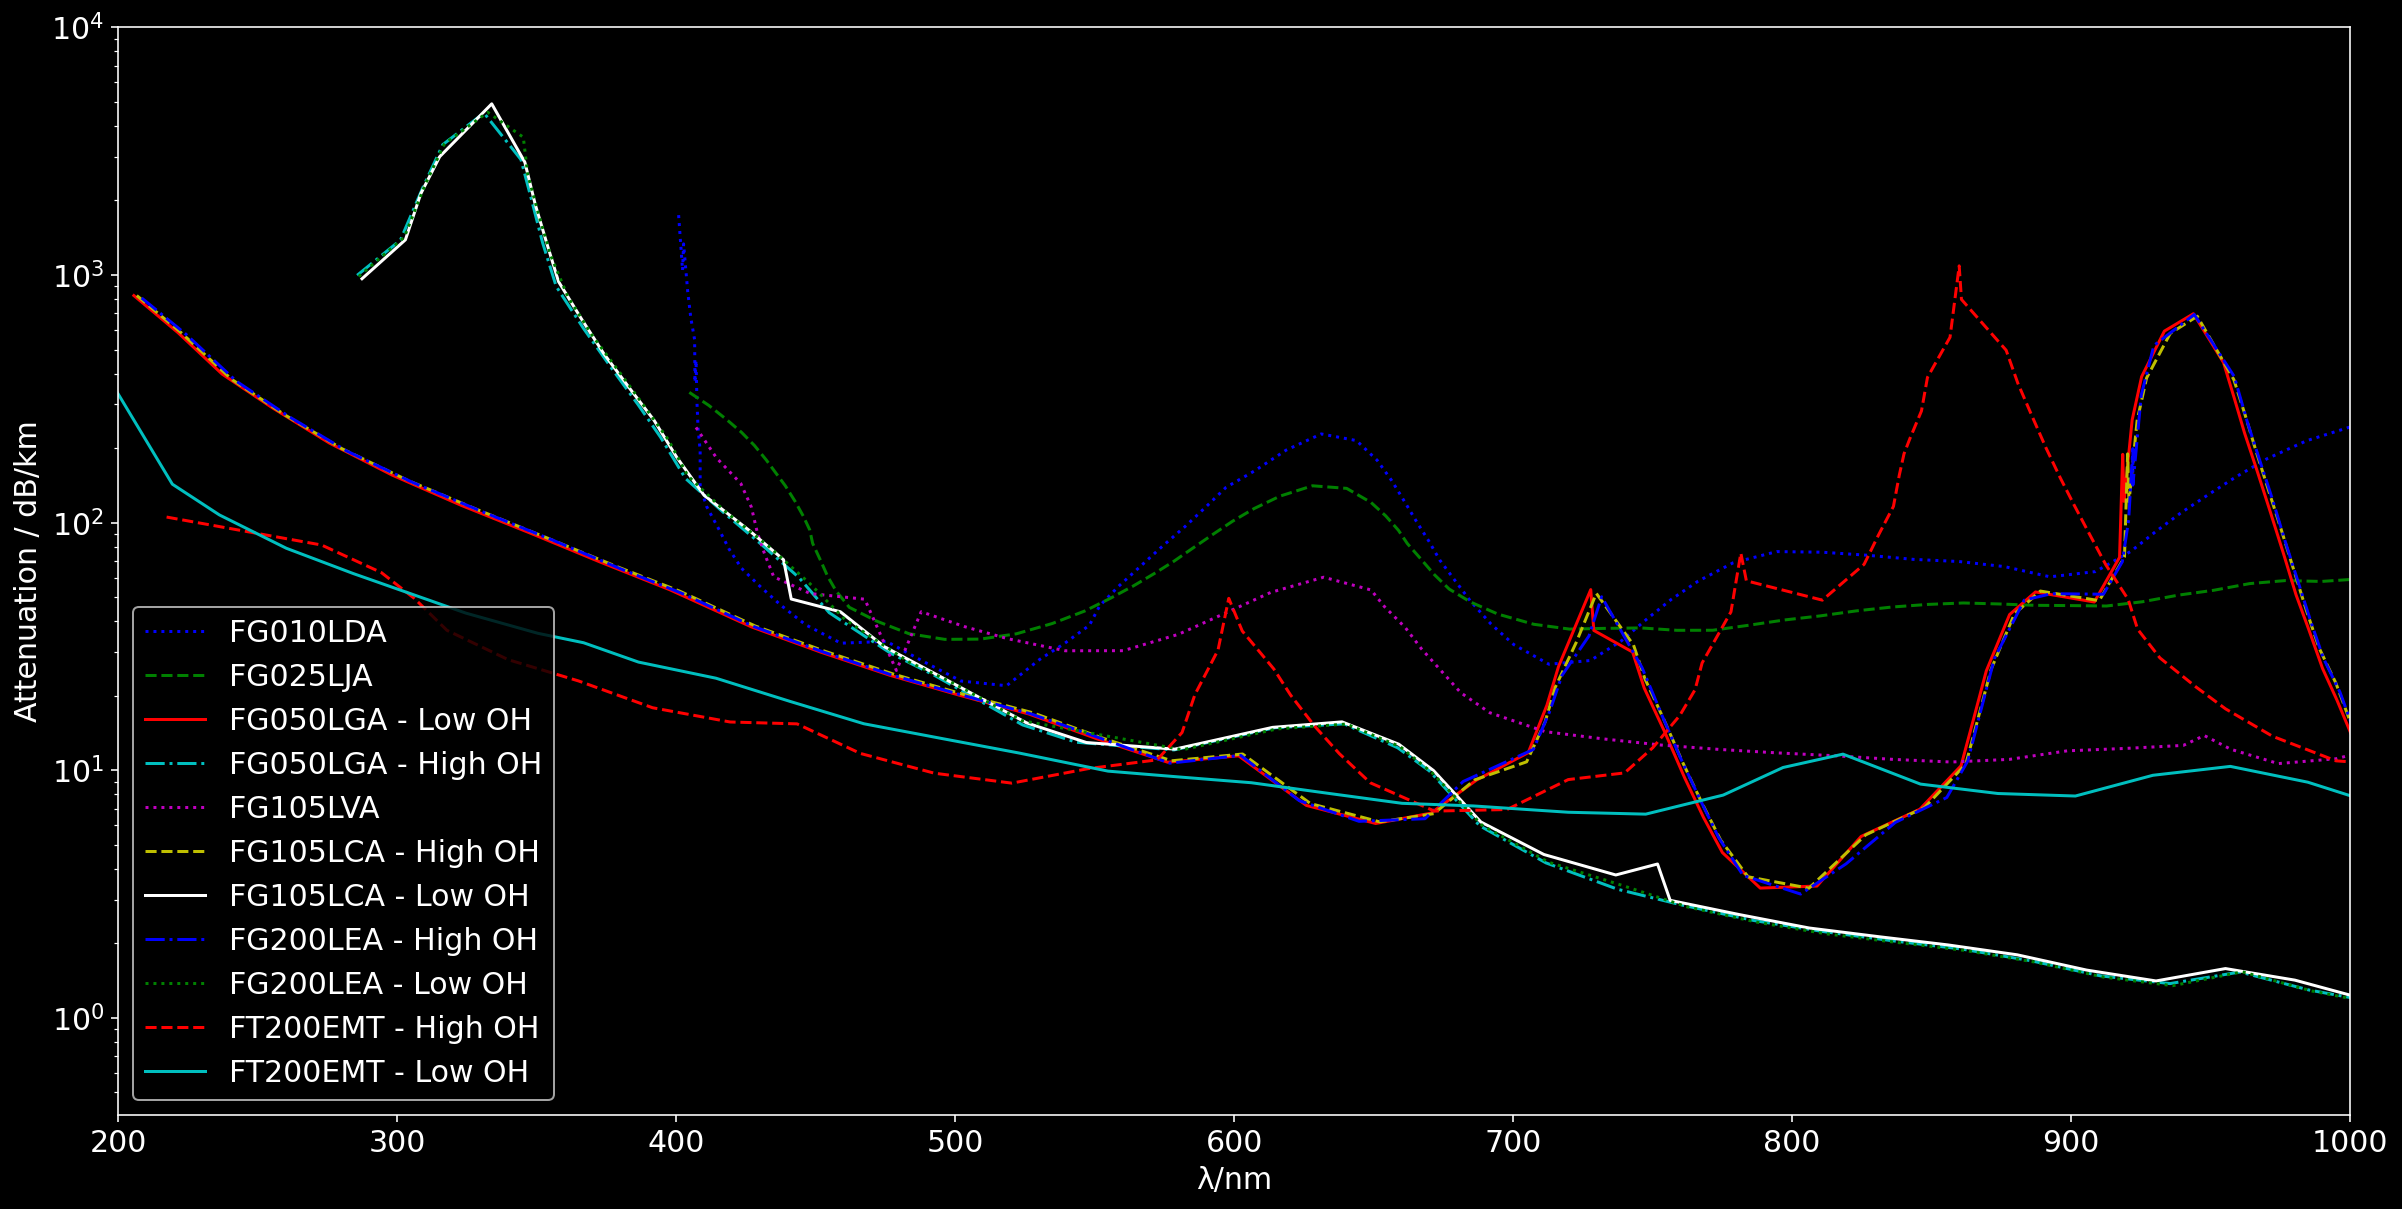

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 15})
for idx, fiber in enumerate(fiber_data):
    print(fiber)
    x , y = fiber_data[fiber]['λ / nm'], fiber_data[fiber]['Attenuation dB / km']
    sorter = np.argsort(x)
    x, y = x[sorter], y[sorter]
    ax.plot(x, y, 
            label=fiber,
            linestyle=[':','--','-','-.'][idx%4])
ax.set_yscale('log')
ax.set_xlabel('λ/nm')
ax.set_ylabel('Attenuation / dB/km')
ax.set_xlim(200, 1000)
ax.set_ylim(None, 1e4)
plt.legend()
plt.show()

## ##FG050LGA

### ###Calculate the allowed propagation constants kz

In [2]:
fiber_spec = {'NA': 0.22,
              'nCore': 1.45,
              'coreRadius':25.,
              'grid_divider': 2,
              'nFree': 1.,
              'free_space_wavelength': 0.600}
fiber_sol = ws.multisolver(fiber_spec, drawPlots=False, verbose=True)

Approx number of complex HE modes:  800
Approx number of TE modes:  28
Approx number of TM modes:  28
Approx number of total modes:  1658
Approx Max n for HE modes:  40
Calculting TE(0,n) propagation constants ...
Calculting TM(0,n) propagation constants ...
Calculting HE(m,n) propagation constants ...
m=53
HE modes = 1590
TE modes = 36
TM modes = 36
TOTAL modes = 1662
FROM_Vnum = 1658


### ###Calculate the numerical mode basis

In [3]:
fiber_sol = ws.calculate_numerical_basis(fiber_sol)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# pickle.dump(fiber_sol, open('eigenbasis-FG050LGA.pkl', 'wb'))

### ###Plot the modes

In [18]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [19]:
a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']
nCore = fiber_sol['nCore']
nCladding = fiber_sol['nCladding']
λfree = fiber_sol['free_space_wavelength']

In [20]:
annotations = []

for modtype in ['TE','TM','HE']:
    solkey = modtype + 'kz'
    for m, kzs in fiber_sol[solkey].items():
        for kzidx, kz in enumerate(kzs):
            γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
            β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)
            annotationTR = '%s(%d,%d)' % (modtype, m, kzidx)
            annotationBR = 'kz=%.3f µm⁻¹' % (kz)
            annotations.append((annotationTR, annotationBR))

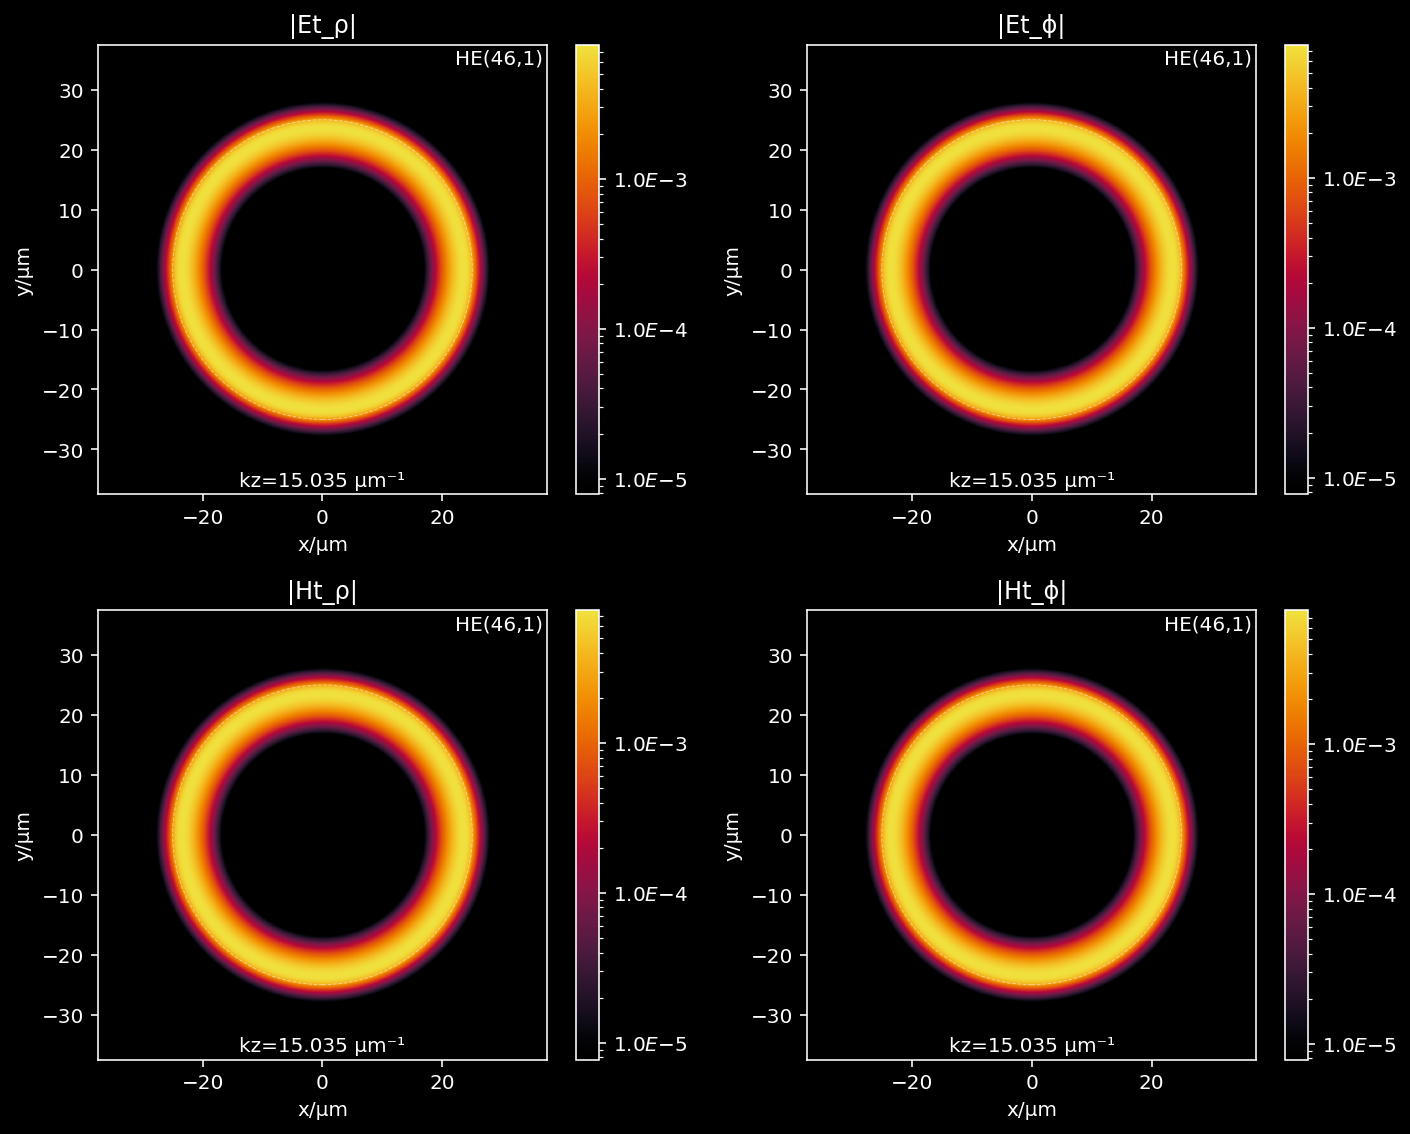

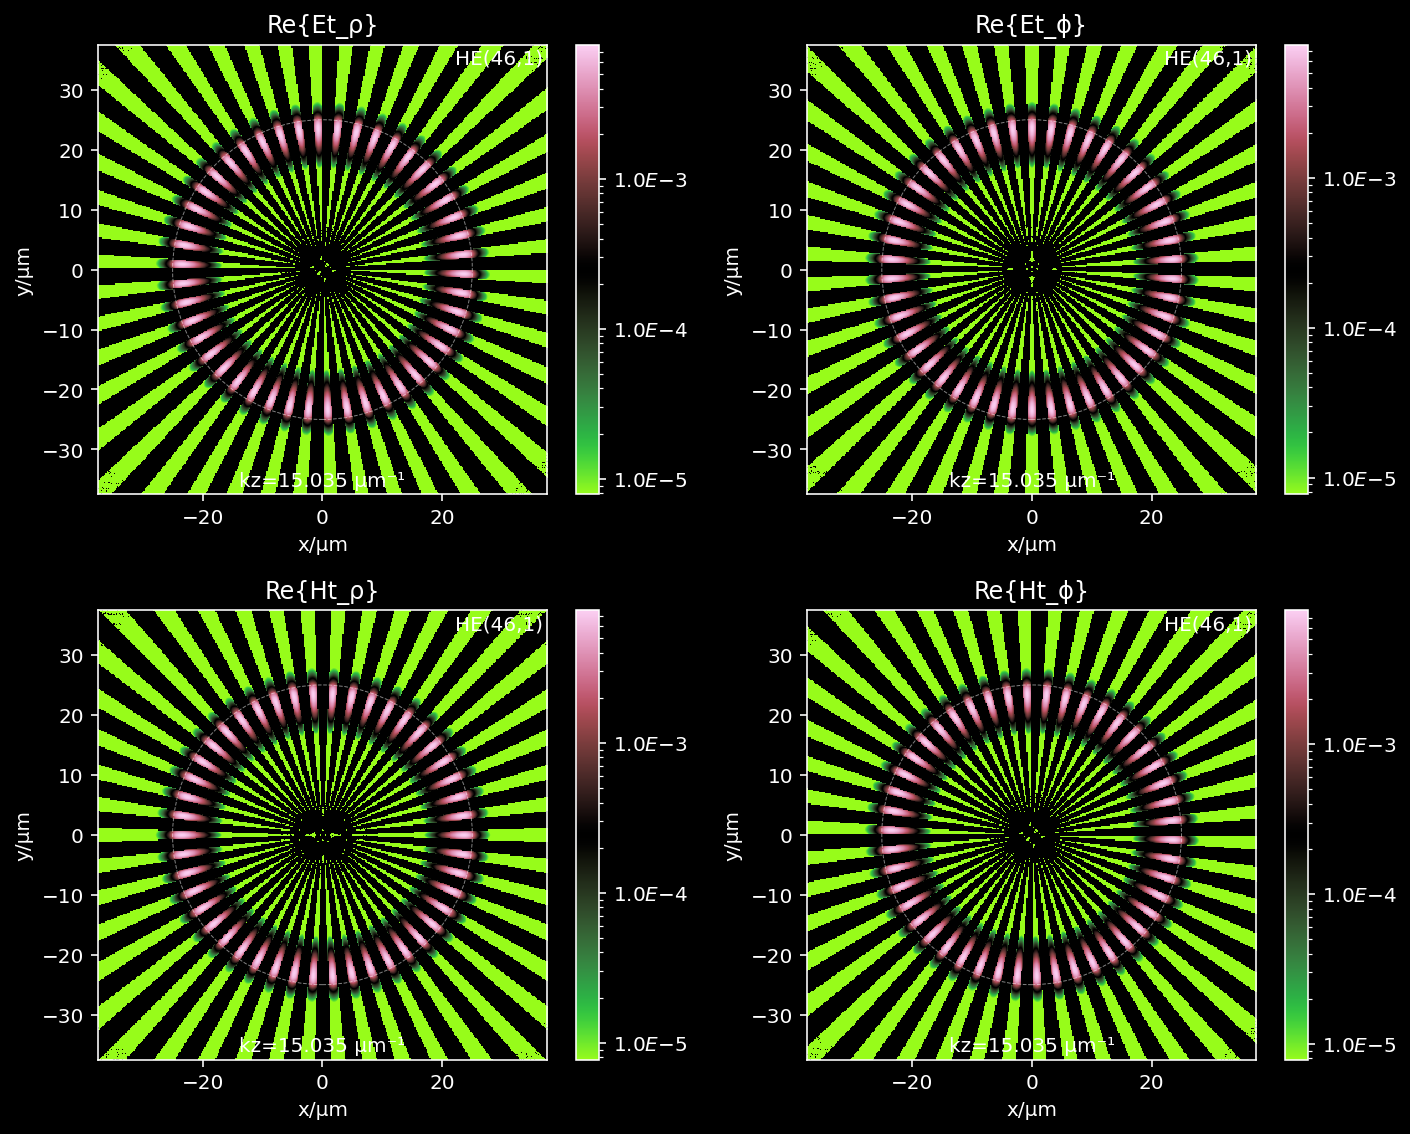

In [45]:
# plot one
def fmt(x, pos):
    if x == 0:
        return '0'
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} E{{{}}}$'.format(a, b)

plt.style.use('dark_background')
component_index = {"Et_ρ":(0,0), "Et_ϕ":(0,1), "Ht_ρ":(1,0), "Ht_ϕ":(1,1)}
index = -10
extent  = [-b,b,-b,b]
for fun_picker in [np.abs, np.real]:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
    if fun_picker in [np.real, np.imag]:
        cmap = cm.watermelon
        if fun_picker == np.real:
            title_format = 'Re{%s}'
        else:
            title_format = 'Im{%s}'
    else:
        cmap = cm.ember
        title_format = '|%s|'
    for component, ci in component_index.items():
        field   = fiber_sol['eigenbasis'][index, ci[0], ci[1], :, :]
        field   = fun_picker(field)
        if np.max(field) == 0 and fun_picker != np.abs:
            if fun_picker == np.real:
                fun_picker = np.imag
                title_format = 'Im{%s}'
            else:
                fun_picker = np.real
                title_format = 'Re{%s}'
            field   = eigenbasis[index, ci[0], ci[1], :, :]
            field   = fun_picker(field)
        axis = axes[ci[0], ci[1]]
        if fun_picker in [np.real, np.imag]:
            themax = np.max(field)
            vmax = themax
            vmin = -themax
        else:
            vmax = np.max(field)
            vmin = 0
        iplot = axis.imshow(field, 
                # vmin=vmin,
                # vmax=vmax,
                norm=LogNorm(vmin=vmax*1e-3, vmax=vmax),
                extent=extent,
                cmap=cmap)
        axis.set_xlabel('x/µm')
        axis.set_ylabel('y/µm')
        axis.set_title(title_format % component)
        axis.text(0.99, 0.99, annotations[index][0], color='w', transform=axis.transAxes, horizontalalignment='right', verticalalignment='top')
        axis.text(0.5, 0.01, annotations[index][1], color='w', transform=axis.transAxes, horizontalalignment='center', verticalalignment='bottom')
        circle = Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5)
        axis.add_patch(circle)
        divider = make_axes_locatable(axis)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        plt.colorbar(iplot, cax=cax, format=ticker.FuncFormatter(fmt))
    plt.tight_layout()
    plt.show()

In [ ]:
# plot and export all
plt.style.use('dark_background')
component_index = {"Et_ρ":(0,0), "Et_ϕ":(0,1), "Ht_ρ":(1,0), "Ht_ϕ":(1,1)}
extent  = [-b,b,-b,b]
for index in tqdm(range(totalModes)):
    for fun_picker in [np.abs, np.real]:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
        if fun_picker in [np.real, np.imag]:
            cmap = cm.watermelon
            if fun_picker == np.real:
                title_format = 'Re{%s}'
            else:
                title_format = 'Im{%s}'
        else:
            cmap = cm.ember
            title_format = '|%s|'
        for component, ci in component_index.items():
            field   = eigenbasis[index, ci[0], ci[1], :, :]
            field   = fun_picker(field)
            if np.max(field) == 0 and fun_picker != np.abs:
                if fun_picker == np.real:
                    fun_picker = np.imag
                    title_format = 'Im{%s}'
                else:
                    fun_picker = np.real
                    title_format = 'Re{%s}'
                field   = fiber_sol['eigenbasis'][index, ci[0], ci[1], :, :]
                field   = fun_picker(field)
            axis = axes[ci[0], ci[1]]
            if fun_picker in [np.real, np.imag]:
                themax = np.max(field)
                vmax = themax
                vmin = -themax
            else:
                vmax = np.max(field)
                vmin = 0
            iplot = axis.imshow(field, 
                    vmin=vmin,
                    vmax=vmax,
                    extent=extent,
                    cmap=cmap)
            axis.set_xlabel('x/µm')
            axis.set_ylabel('y/µm')
            axis.set_title(title_format % component)
            axis.text(0.99, 0.99, annotations[index][0], color='w', transform=axis.transAxes, horizontalalignment='right', verticalalignment='top')
            axis.text(0.5, 0.01, annotations[index][1], color='w', transform=axis.transAxes, horizontalalignment='center', verticalalignment='bottom')
            circle = Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5)
            axis.add_patch(circle)
            divider = make_axes_locatable(axis)
            cax = divider.append_axes("right", size="5%", pad=0.2)
            plt.colorbar(iplot, cax=cax, format=ticker.FuncFormatter(fmt))
        plt.tight_layout()
        if fun_picker in [np.real, np.imag]:
            fname = './FG050LGA/reim/mode-%d.png' % index
        else:
            fname = './FG050LGA/abs/mode-%d.png' % index
        plt.savefig(fname)
        plt.close()

### ###Launching fields across the end of the waveguide

In [9]:
totalModes = fiber_sol['totalModes']
λfree = fiber_sol['free_space_wavelength']
eigenbasis = fiber_sol['eigenbasis']
nCore = fiber_sol['nCore']
nCladding = fiber_sol['nCladding']
a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']

In [10]:
annotations = []

for modtype in ['TE','TM','HE']:
    solkey = modtype + 'kz'
    for m, kzs in fiber_sol[solkey].items():
        for kzidx, kz in enumerate(kzs):
            γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
            β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)
            annotationTR = '%s(%d,%d)' % (modtype, m, kzidx)
            annotationBR = 'kz=%.3f µm⁻¹' % (kz)
            annotations.append((annotationTR, annotationBR))

In [11]:

indexPercent = 0.1
index = int(indexPercent * totalModes)
nFree = 1.0
annot = annotations[index]
# pick the E and H fields
Einc = eigenbasis[index, 0, :, :, :]
Hinc = np.conjugate(eigenbasis[index, 1, :, :, :])
kref, Eref, Href = ws.poyntingrefractor(Einc, Hinc, nFree, nxy, verbose=True)

Calculating the Poynting vector field...
Calculating the magnitude of the Poynting field...
Calculating the transverse component of the Poynting field...
Calculating the unit vector in the direction of the Poynting vector...
Calculating the angle of incidence field...
Calculating the angle of refraction field...
Calculating the Fresnel coefficients...
Calculating the ζ of the local coord system...
Calculating the S and P component of the incident electric field...
Calculating the S and P component of the refracted electric field...
Calculating the total refracted electric field...
Calculating the refracted wavevector (normalized) field...
Calculating the refracted H field...


#### ####Spaguetti code

In [ ]:
# given a field (Ex, Ey, Ez) at a plane calculate the discrete
# fourier transform of the field in the x,y,z directions
# this would provide the field in the frequency domain
# the field is assumed to be periodic in the x,y,z directions
fiberfield_t = np.copy(eigenbasis[0,0,:,:,:])
# at the moment I haven't calculate the z component of the field
# let me just assume a z component that is roughly of the same magnitude 
# of the x and y components, that starts normal at the center and
# deviates to the NA of the fiber at the edge of it

In [ ]:
Ex = fiberfield_t[0,:,:]
Ey = fiberfield_t[1,:,:]
NA = fiber_sol['NA']
nCore = fiber_sol['nCore']
a = fiber_sol['coreRadius']
thetamax = np.arcsin(NA/nCore)
# calculate the magnitude of the transverse field
r = np.sqrt(Xg**2+Yg**2)
# calculate the angle of E at each point
launchAngle = thetamax/a * r
# knowing the angle at each position I should be able to "calculate"
# the z component of the field
# this doesn't make any sense, the direction of the
# electric field is not the direction of the wave vector
# ok, instead let me estimate the direction of the wave vector
# across the fiber and then use that together with the field at 
# each position to determine what is a compatible value for the z component
kmag = 2*np.pi/λfree*nCore
dirfield = np.arctan2(Yg, Xg)
xhat = np.cos(dirfield)
yhat = np.sin(dirfield)
kz = kmag * np.cos(launchAngle)
kx = kmag * np.sin(launchAngle) * xhat
ky = kmag * np.sin(launchAngle) * yhat
# at every point 
# now let me make
# use this to calculate a possible z component for E
dotEk = fiberfield_t[0,:,:] * kx + fiberfield_t[1,:,:] * ky
Ez = -dotEk/kz
# in this construction the electric field is always in parallel to the plane of incidence
fresnel = (2 * nCore * 1 * np.cos(launchAngle)
           / (1 * np.cos(launchAngle) + nCore * np.sqrt(1-nCore**2*np.sin(launchAngle)**2)))
Erefracted_x = fresnel * Ex
Erefracted_y = fresnel * Ey
Erefracted_z = fresnel * Ez

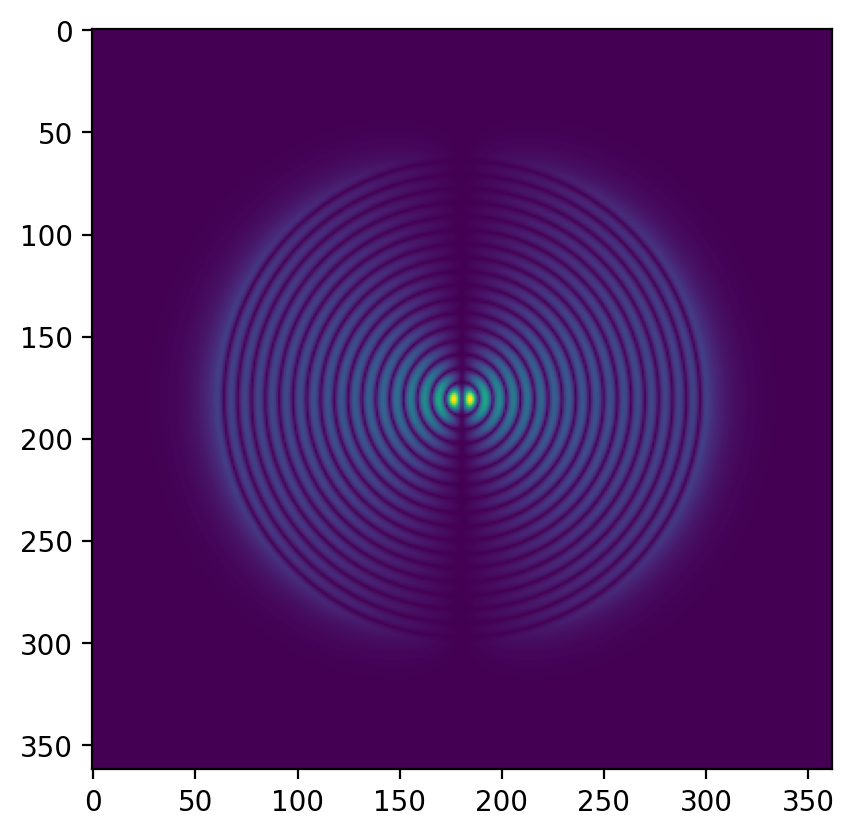

In [ ]:
plt.figure()
plt.imshow(np.abs(Erefracted_x))
plt.show()

In [ ]:
# ok, next part
# i need to find the farfield for the refracted field
# i think I have
apertureRadius = b
λ = λfree
k = 2 * np.pi / λ
replicas = 1
dist_to_ML = 20
zmax = dist_to_ML * 5
farfield_axis = np.linspace(0,zmax,100)
L = 2 * apertureRadius # spatial extent of the field
field = Erefracted_x
dx = L / field.shape[0]
idx_width = field.shape[0]
if replicas != 1:
    nearfourier.shape = np.pad(field,(idx_width, idx_width))
else:
    F = field
kx = 2 * np.pi * (np.fft.fftfreq(F.shape[0], d=dx))
ky = kx
kx, ky = np.meshgrid(kx, ky)
kz = np.sqrt(k**2 - kx**2 - ky**2 + 0j)

gator = 1.j * np.outer(farfield_axis, kz)
gator = gator.reshape((*farfield_axis.shape, *kz.shape))
gator = np.exp(gator)


In [ ]:
np.arcsin(NA)/np.pi*180

12.709032994395436

In [ ]:
gator.shape

(100, 362, 362)

In [ ]:
import cmasher as cmr

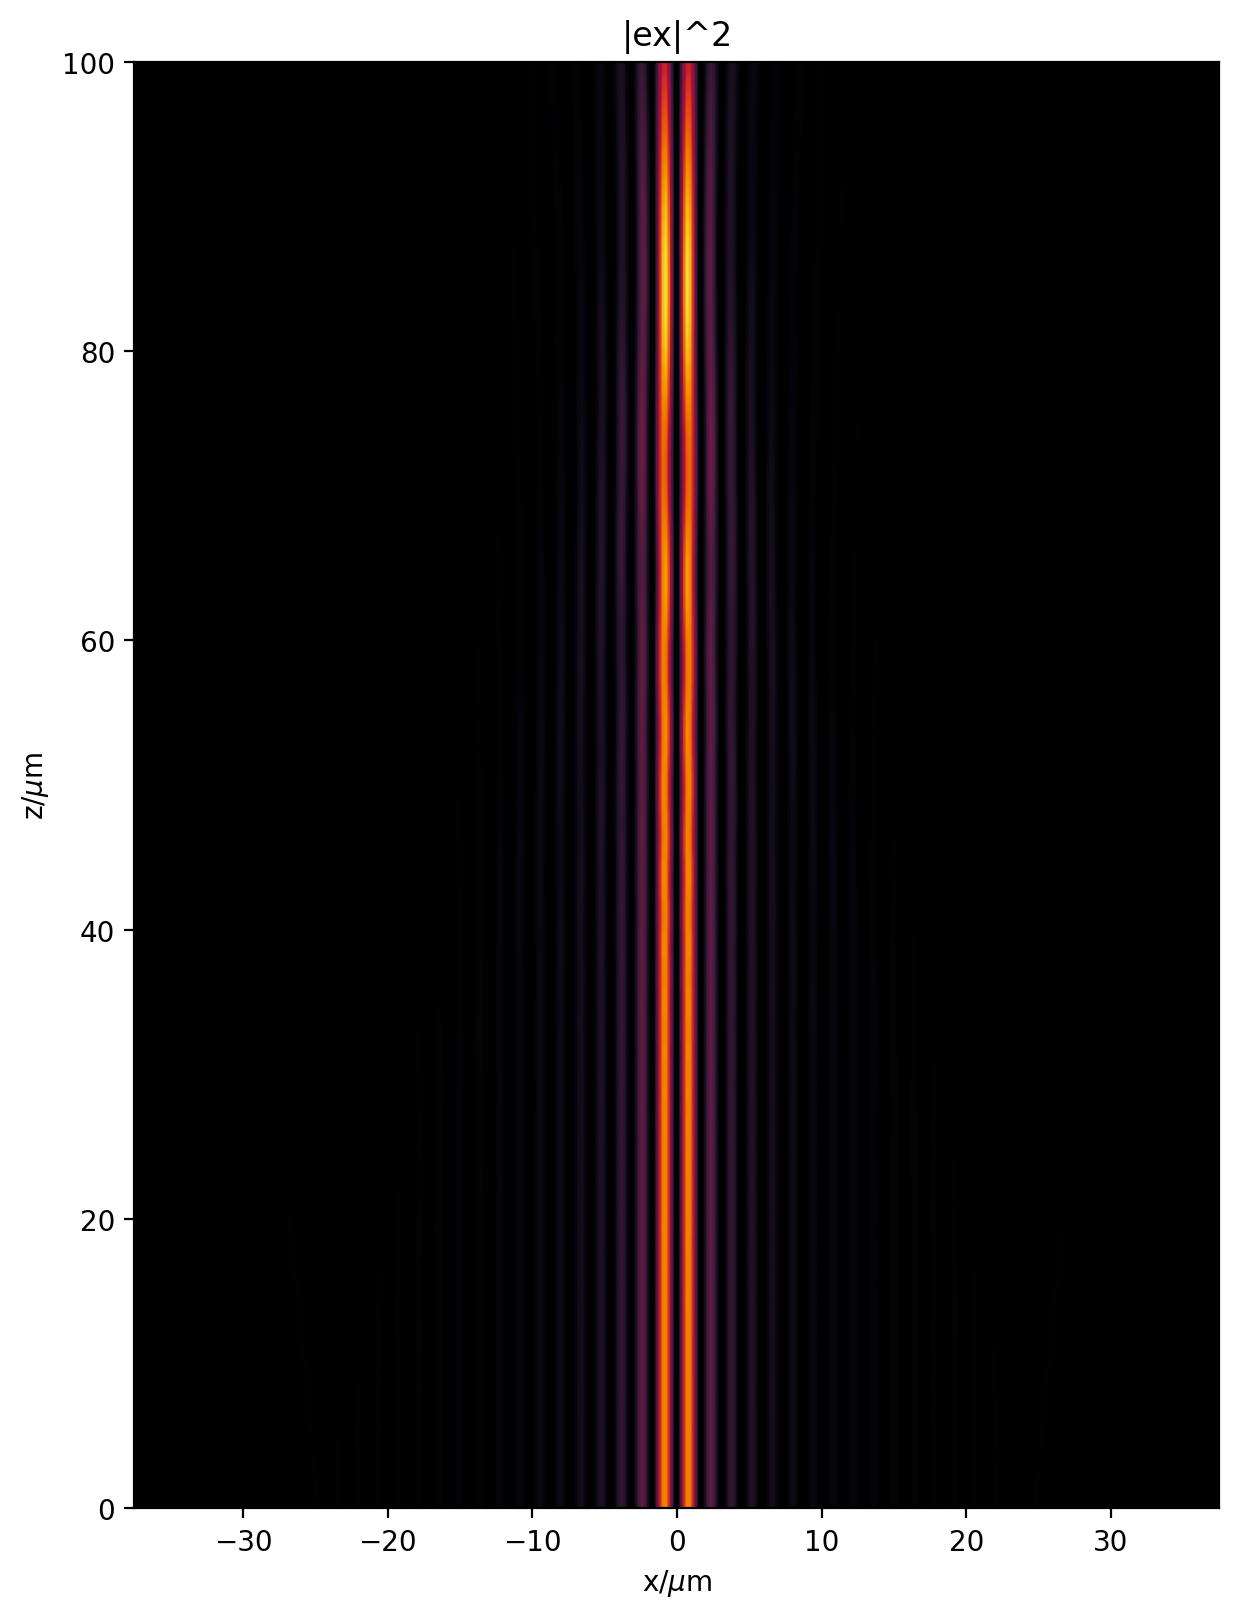

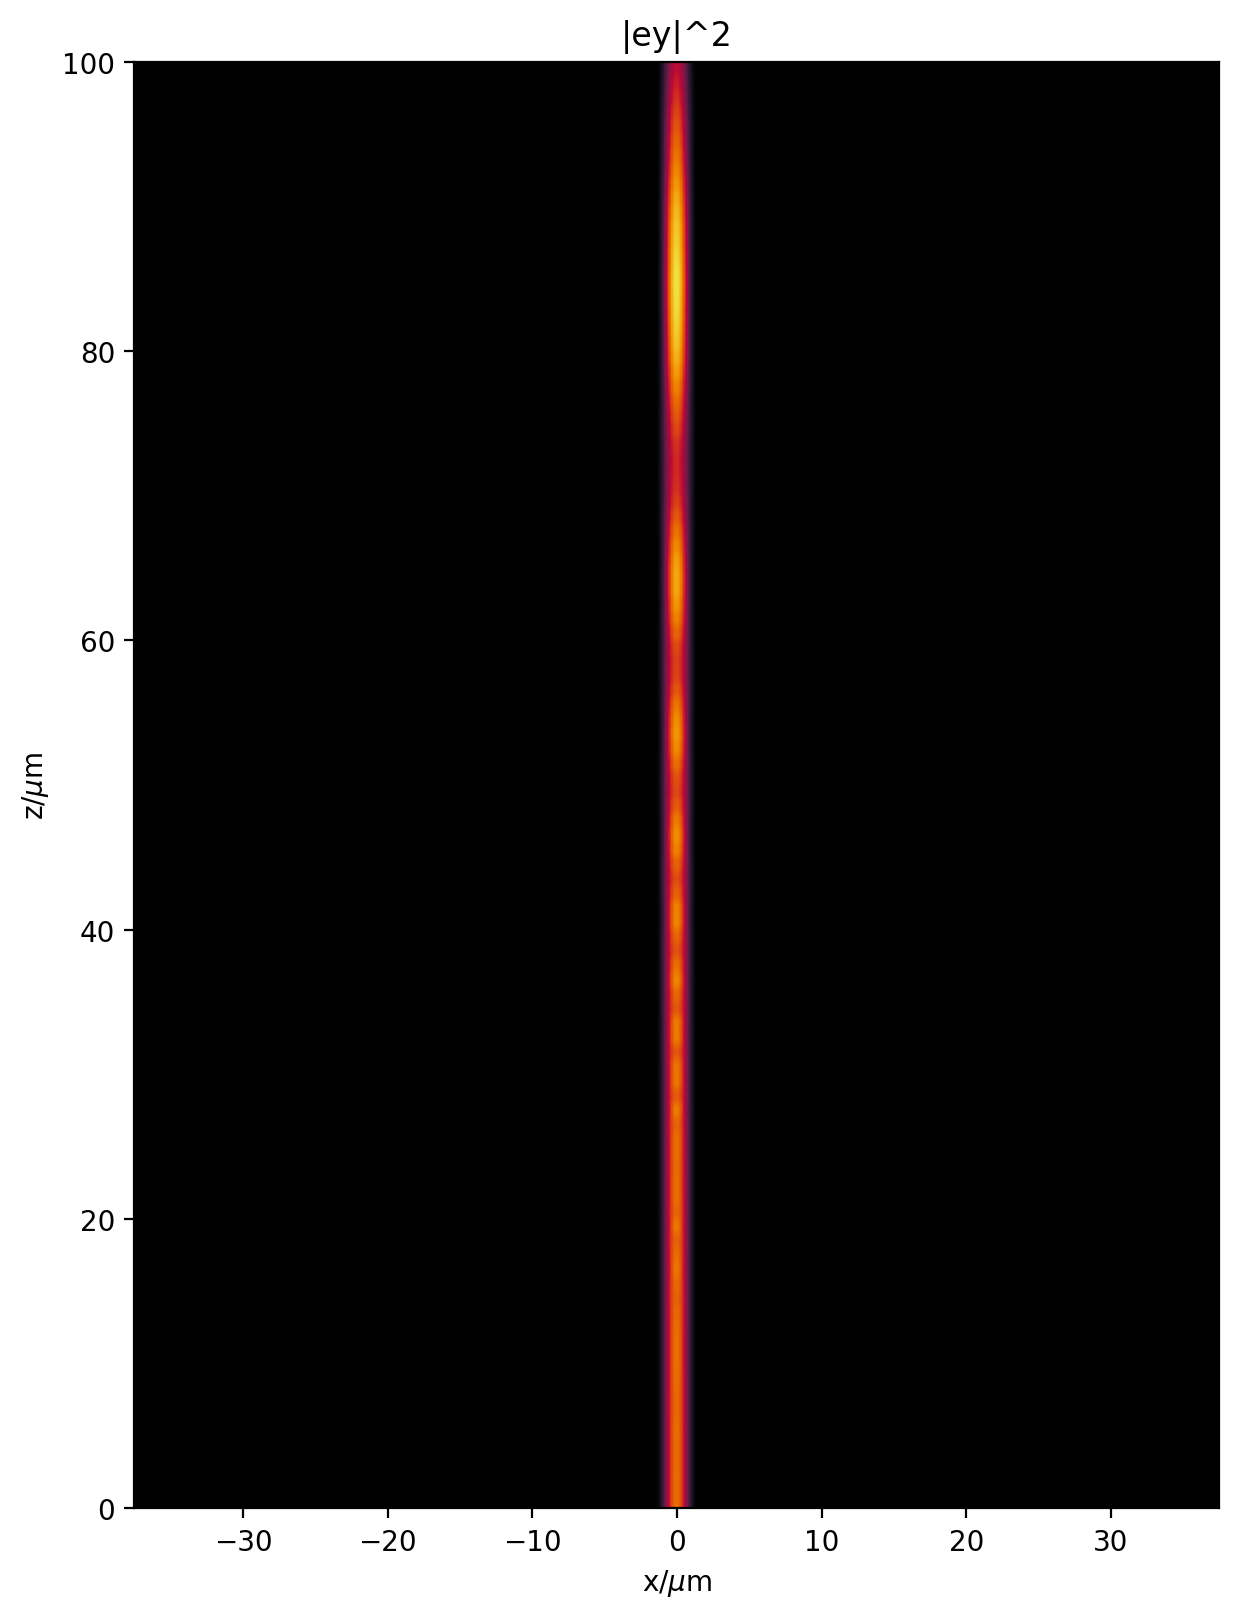

In [ ]:
farfields = {}
fields = {'ex':Erefracted_x, 'ey':Erefracted_y}
for field_component in ['ex','ey']:
    field = fields[field_component]
    dx = L / field.shape[0]
    idx_width = field.shape[0]
    F = field
    # calculate the Fourier transform of the nearfield
    nearfourier = np.fft.fft2(F)
    # multiply by the farfield propagator
    farfourier = nearfourier * gator
    # calculate the inverse Fourier transform
    farfield = np.fft.ifft2(farfourier)

    extent = [-L/2 * replicas, L/2 * replicas, 0, zmax]
    # get the field on the zx plane
    pfield = np.abs(farfield[::,farfield.shape[-2]//2])**2
    farfields[field_component] = pfield

    plt.figure(figsize=(7,10))
    plt.imshow(pfield,
            cmap = cmr.ember,
            extent = extent,
            origin='lower')
    plt.xlim(-L/2, L/2)
    plt.xlabel('x/$\mu$m')
    plt.ylabel('z/$\mu$m')
    plt.title('|%s|^2' % field_component)
#     plt.colorbar()
    plt.show()

### ###Poynting vectors and angles of incidence

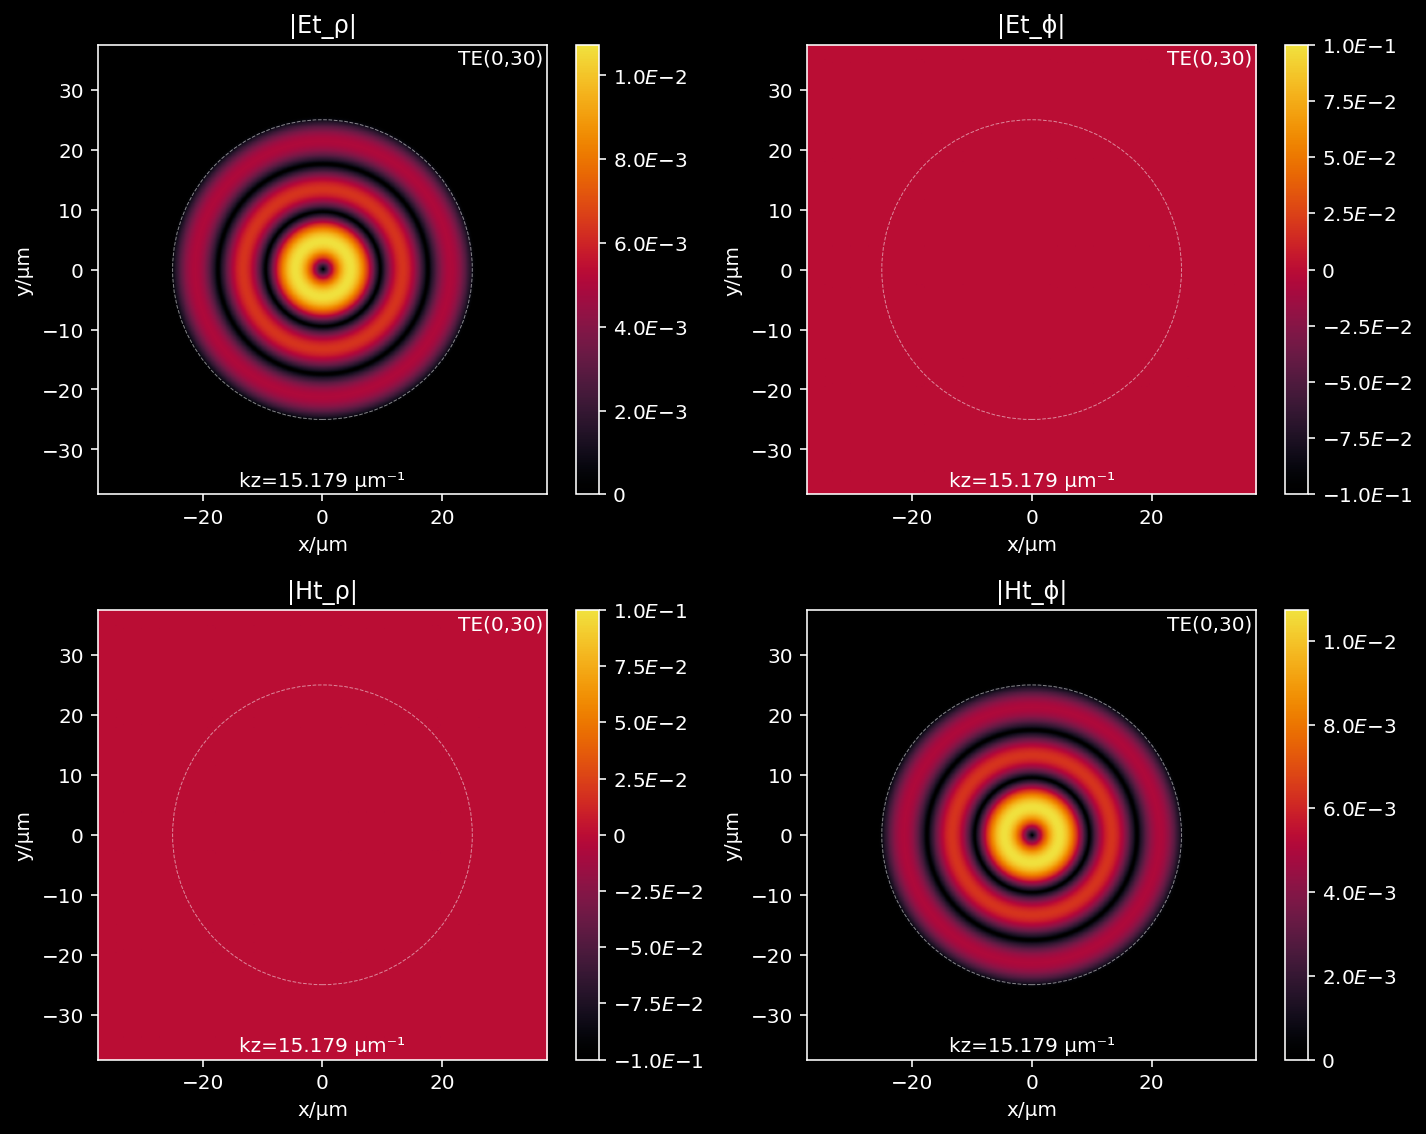

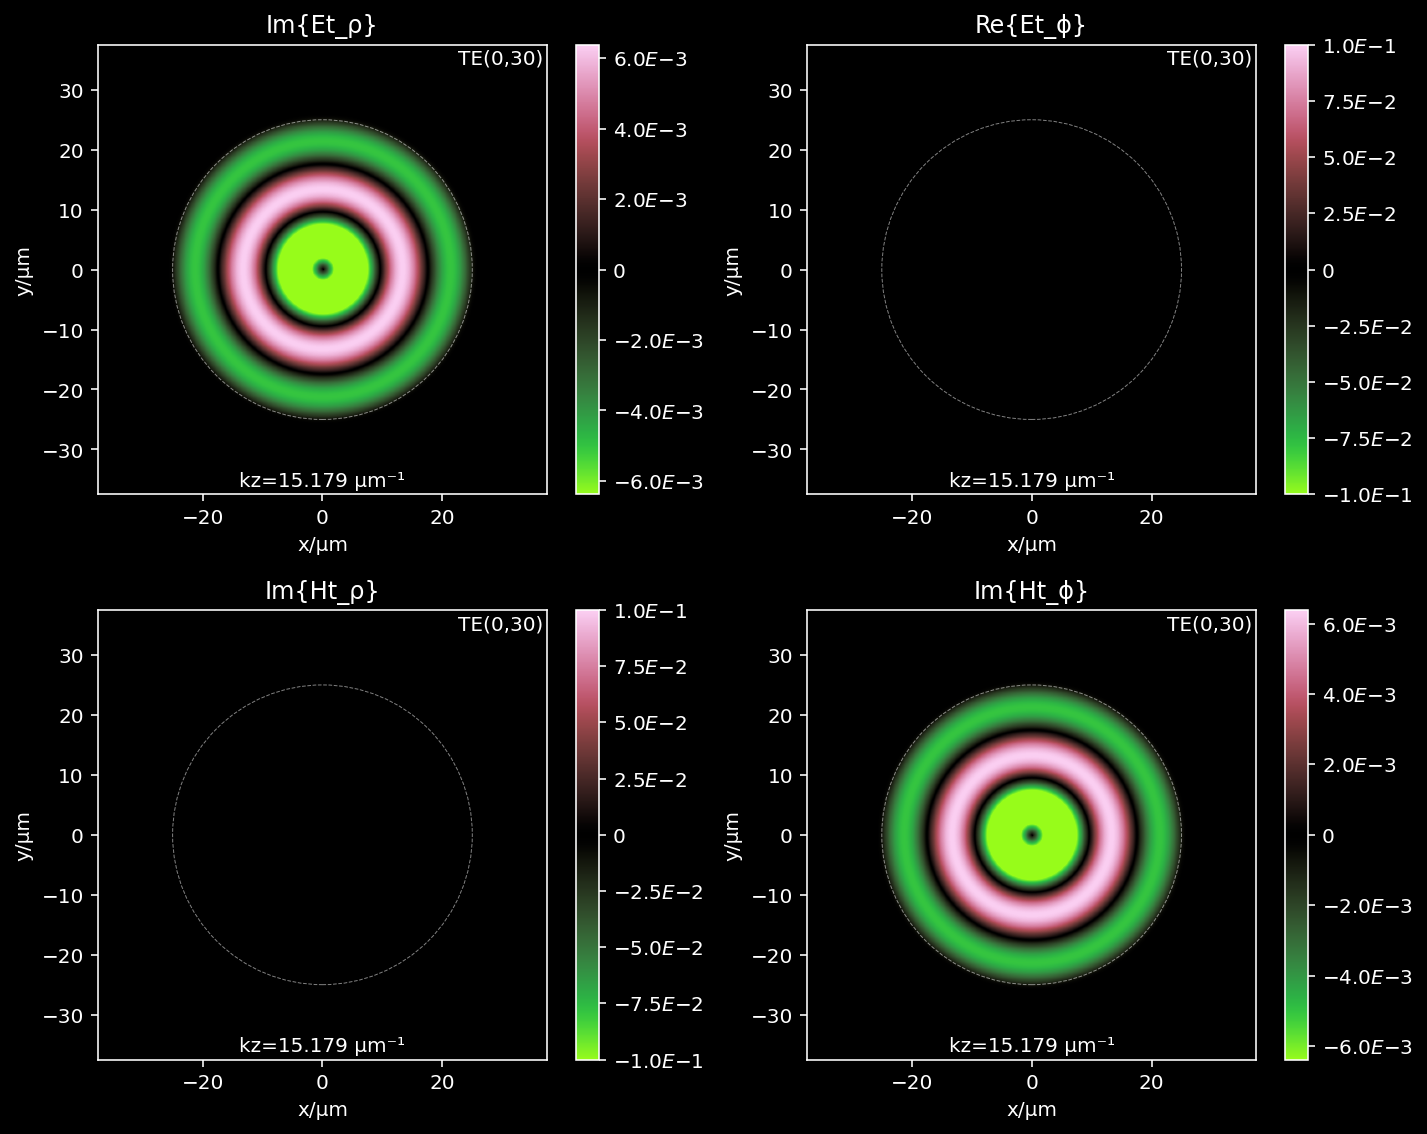

In [ ]:
plt.style.use('dark_background')
component_index = {"Et_ρ":(0,0), "Et_ϕ":(0,1), "Ht_ρ":(1,0), "Ht_ϕ":(1,1)}
index = 30
extent  = [-b,b,-b,b]
for fun_picker in [np.abs, np.real]:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
    if fun_picker in [np.real, np.imag]:
        cmap = cm.watermelon
        if fun_picker == np.real:
            title_format = 'Re{%s}'
        else:
            title_format = 'Im{%s}'
    else:
        cmap = cm.ember
        title_format = '|%s|'
    for component, ci in component_index.items():
        field   = eigenbasis[index, ci[0], ci[1], :, :]
        field   = fun_picker(field)
        if np.max(field) == 0 and fun_picker != np.abs:
            if fun_picker == np.real:
                fun_picker = np.imag
                title_format = 'Im{%s}'
            else:
                fun_picker = np.real
                title_format = 'Re{%s}'
            field   = eigenbasis[index, ci[0], ci[1], :, :]
            field   = fun_picker(field)
        axis = axes[ci[0], ci[1]]
        if fun_picker in [np.real, np.imag]:
            themax = np.max(field)
            vmax = themax
            vmin = -themax
        else:
            vmax = np.max(field)
            vmin = 0
        iplot = axis.imshow(field, 
                vmin=vmin,
                vmax=vmax,
                extent=extent,
                cmap=cmap)
        axis.set_xlabel('x/µm')
        axis.set_ylabel('y/µm')
        axis.set_title(title_format % component)
        axis.text(0.99, 0.99, annotations[index][0], color='w', transform=axis.transAxes, horizontalalignment='right', verticalalignment='top')
        axis.text(0.5, 0.01, annotations[index][1], color='w', transform=axis.transAxes, horizontalalignment='center', verticalalignment='bottom')
        circle = Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5)
        axis.add_patch(circle)
        divider = make_axes_locatable(axis)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        plt.colorbar(iplot, cax=cax, format=ticker.FuncFormatter(fmt))
    plt.tight_layout()
    plt.show()

In [ ]:
# coord_layout = coordinate_layout(fiber_sol)
# a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask = coord_layout

In [ ]:
# # get a mode
# index = 30
# Efield = eigenbasis[index, 0, :, :, :]
# Hfield = np.conjugate(eigenbasis[index, 1, :, :, :])

# # #EXH-Calc
# Sfield = 0.5*np.real(np.cross(Efield, Hfield, axis=0))

# # #normIncident-Calc
# Sfieldmag = np.sqrt(Sfield[0,:,:]**2 + Sfield[1,:,:]**2 + Sfield[2,:,:]**2)
# Stransverse = np.sqrt(Sfield[0,:,:]**2 + Sfield[1,:,:]**2)
# dirField = np.arctan2(Stransverse,
#                       Sfield[2, :, :])

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
implot = axes[0].imshow(dirField,
           extent=extent, 
           cmap=cm.ember)
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.2)
circle = Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5)
axes[0].add_patch(circle)
axes[0].set_xlabel('x/µm')
axes[0].set_ylabel('y/µm')
axes[0].set_title('|β|')
plt.colorbar(implot, cax=cax)
implot = axes[1].imshow(Sfieldmag,
           extent=extent, 
           cmap=cm.ember)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.2)
circle = Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5)
axes[1].add_patch(circle)
axes[1].set_xlabel('x/µm')
axes[1].set_ylabel('y/µm')
axes[1].set_title('|S|')
plt.colorbar(implot, cax=cax)
plt.tight_layout()
plt.show()

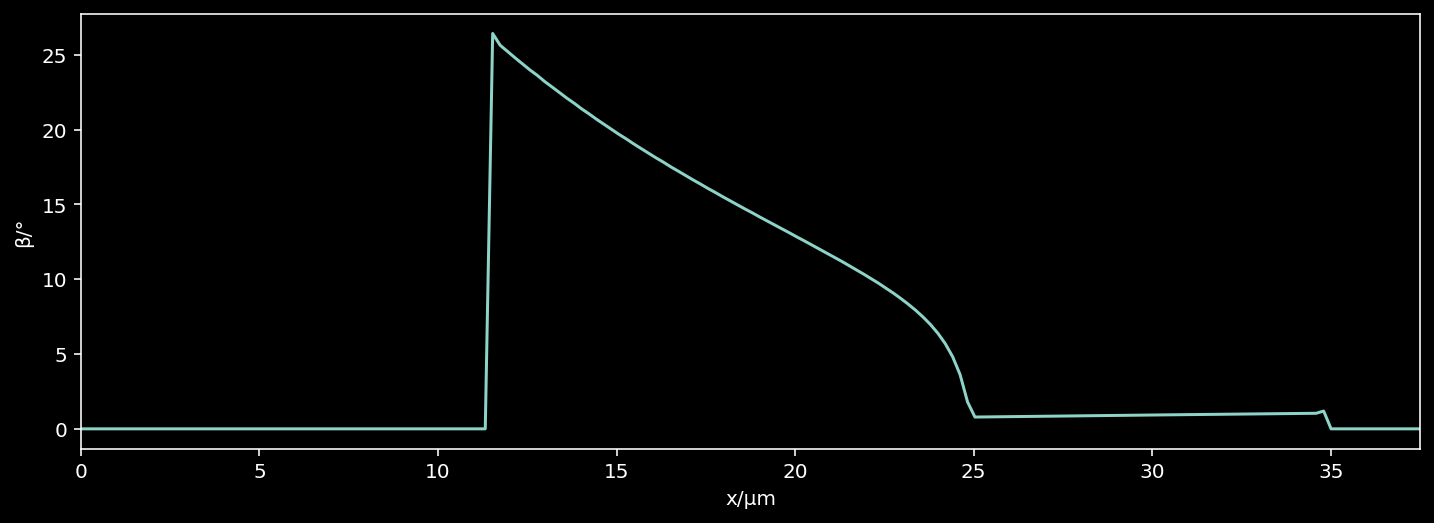

In [ ]:
midindex = dirField.shape[0]//2
diameter = dirField[midindex]
ρfull = np.linspace(-b, b, dirField.shape[0])
plt.figure(figsize=(12, 4))
plt.plot(ρfull, diameter * 180 / np.pi)
plt.xlim(0,b)
plt.xlabel('x/µm')
plt.ylabel('β/°')
plt.show()

In [ ]:
index = -10
Efield = eigenbasis[index, 0, :, :, :]
Hfield = np.conjugate(eigenbasis[index, 1, :, :, :])

In [ ]:
np.sum(np.abs(Efield[0]**2)+np.abs(Efield[1]**2)+np.abs(Efield[2]**2))

0.9999999

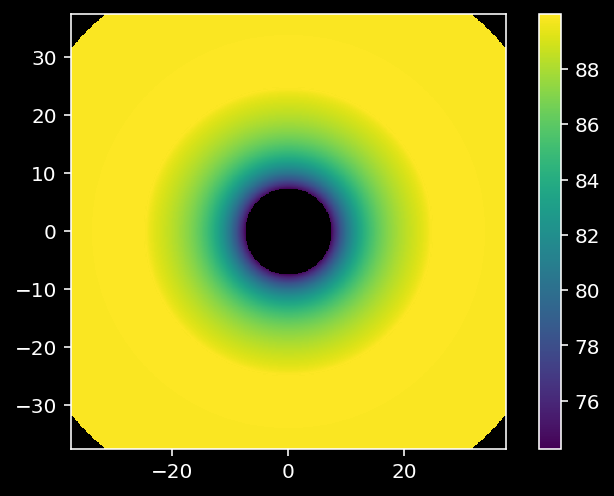

In [ ]:
dotprod = (Efield[0]*np.conjugate(Hfield[0]) + Efield[1]*np.conjugate(Hfield[1]) + Efield[2]*np.conjugate(Hfield[2]))
dotprod /= np.sqrt(np.sum(np.abs(Efield)**2, axis=0)) * np.sqrt(np.sum(np.abs(Hfield)**2, axis=0))
dotangle = np.arccos(np.abs(dotprod)) * 180 / np.pi
plt.figure()
plt.imshow(dotangle, extent=extent)
plt.colorbar()
plt.show()

In [ ]:
# Efield = eigenbasis[index, 0, :, :, :]
# Hfield = np.conjugate(eigenbasis[index, 1, :, :, :])
# Sfield = 0.5*np.real(np.cross(Efield, Hfield, axis=0))
# Sfieldmag = np.sqrt(Sfield[0,:,:]**2 + Sfield[1,:,:]**2 + Sfield[2,:,:]**2)
# Stransverse = np.sqrt(Sfield[0,:,:]**2 + Sfield[1,:,:]**2)
# dirField = np.arctan2(Stransverse,
#                       Sfield[2, :, :])

In [418]:
a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']
eigenbasis = fiber_sol['eigenbasis']
totalModes = fiber_sol['totalModes']

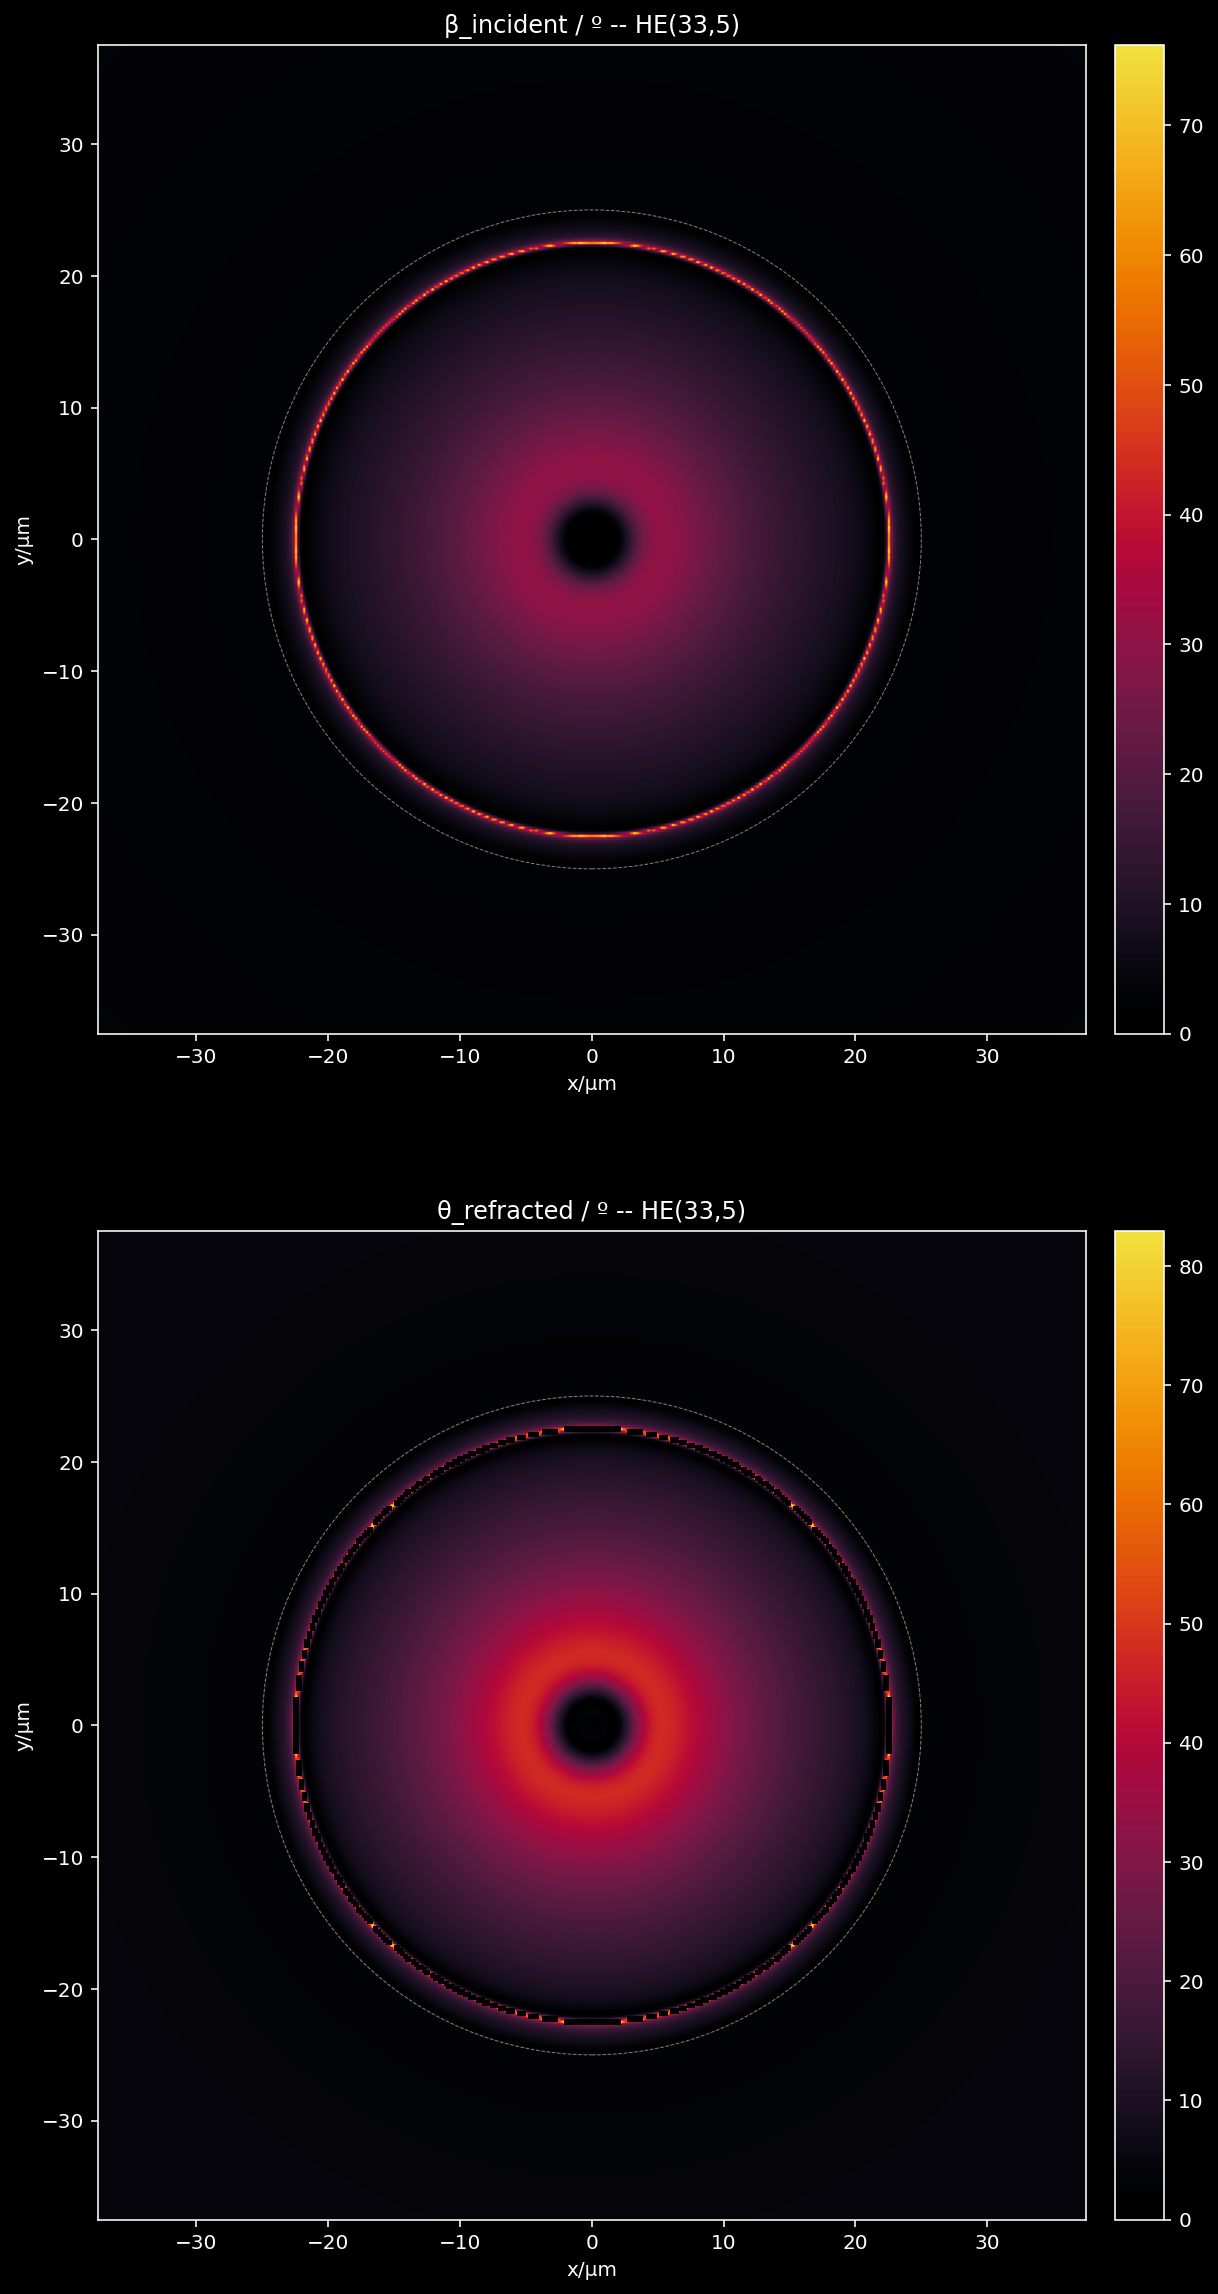

In [136]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 20))
im = axes[0].imshow(βfield/np.pi*180,
          cmap=cm.ember,
          extent=extent)
axes[0].add_patch(Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5))
axes[0].set_xlabel('x/µm')
axes[0].set_ylabel('y/µm')
axes[0].set_title('β_incident / º -- ' + annot[0])
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

im = axes[1].imshow(θfield/np.pi*180,
          cmap=cm.ember,
          extent=extent)
axes[1].add_patch(Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5))
axes[1].set_xlabel('x/µm')
axes[1].set_ylabel('y/µm')
axes[1].set_title('θ_refracted / º -- ' + annot[0])
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

plt.show()

In [285]:
# get a mode
indexPercent = 0.9
index = int(indexPercent * totalModes)
nFree = 1.0
annot = annotations[index]
# pick the E and H fields
Efield = eigenbasis[index, 0, :, :, :]
Hfield = np.conjugate(eigenbasis[index, 1, :, :, :])

# #EXH-Calc
# calculate the Poynting vector
Sfield = 0.5*np.real(np.cross(Efield, Hfield, axis=0))


# #normIncidentk-Calc
# calculate the magnitude of the Poynting field
Sfieldmag = np.sqrt(np.sum(Sfield**2, axis=0))
# calculate the transverse component of the Poynting vector
Stransverse = np.sqrt(Sfield[0,:,:]**2 + Sfield[1,:,:]**2)
# calculate the direction of the Poynting vector use that to estimate angles of incidence
# here it's assumed that the normal is pointing in the +z direction
# #β-Calc
βfield = np.arctan2(Stransverse, Sfield[2, :, :])
# #θ-Calc
θfield = np.arcsin(nxy/nFree * np.sin(βfield))
# calculate the unit vector in the direction of the Poynting vector
kfield = Sfield / Sfieldmag
numNans_k = np.sum(np.isnan(kfield))
numNans_β = np.sum(np.isnan(βfield))
numNans_θ = np.sum(np.isnan(θfield))
print("kfield has {} NaNs".format(numNans_k))
print("βfield has {} NaNs".format(numNans_β))
print("θfield has {} NaNs".format(numNans_θ))

# #FresnelS-Calc
# #FresnelP-Calc
# These I can calculate using the refractive indices and the angles of incidence
# S is perpendicular to plane of incidence
fresnelS = (2 * nxy * np.cos(βfield) 
            / ( nxy * np.cos(βfield) 
               + np.sqrt(nFree**2 
                               - nxy**2 * np.sin(βfield)**2)
                )
            )
fresnelP = (2 * nFree * nxy * np.cos(βfield) 
            / (nFree**2 * np.cos(βfield) 
               +  nxy * np.sqrt(nFree**2 
                          - nxy**2 * np.sin(βfield)**2)
                )
            )


# #ζ-Calc
# calculate the unit vector field perpendicular to the plane of incidence
# which is basically k X z
ζfield = np.zeros(kfield.shape)
ζfield[0] = kfield[1]
ζfield[1] = -kfield[0]
# normalize the ζfield
ζfield /= np.sqrt(np.sum(np.abs(ζfield)**2, axis=0))

# decompose the field in P and S polarizations
# first find P-pol and then use the complement to determine S-pol
# the S-pol can be obtained by the dot product of E with ζ
#EincS-Calc
ESdot = Efield[0,:,:] * ζfield[0] + Efield[1,:,:] * ζfield[1]
EincS = np.zeros(ζfield.shape)
EincS[0] = ESdot[0] * ζfield[0]
EincS[1] = ESdot[1] * ζfield[1]
#EincP-Calc
EincP = Efield - EincS
del ESdot

#ErefS-Calc
ErefS = np.zeros(Efield.shape)
ErefS[0] = fresnelS * EincS[0]
ErefS[1] = fresnelS * EincS[1]
ErefS[2] = fresnelS * EincS[2]

#ErefP-Calc
ErefP = np.zeros(Efield.shape)
ErefP[0] = fresnelP * EincP[0]
ErefP[1] = fresnelP * EincP[1]
ErefP[2] = fresnelP * EincP[2]

#Eref-Calc
Eref  = ErefS + ErefP

#kref-Calc
ξfield    = np.zeros(ζfield.shape)
ξfield[0] = -ζfield[1]
ξfield[1] = ζfield[0]
kref      = np.zeros(kfield.shape)
kref[0]   = np.sin(θfield) * ξfield[0]
kref[1]   = np.sin(θfield) * ξfield[1]
kref[2]   = np.cos(θfield)

#Href-Calc
Href = nFree * np.cross(kref, Eref, axis=0)

kfield has 3 NaNs
βfield has 0 NaNs
θfield has 472 NaNs


In [286]:
# def poyntingrefractor(Efield, Hfield, nxy, nFree, verbose=False):
#     '''
#     Approximate the refracted field across a planar   interface
#     using the Poynting vector as an analog to the wavevector of
#     a plane-wave.

#     Parameters
#     ----------
#     Efield : np.array (3, N, M)
#         The electric field incident on the interface.
#     Hfield : np.array (3, N, M)
#         The H-field incident on the interface.
#     nxy : np.array    (N, M)
#         The refractive index transverse to the interface inside the incident medium.
#     nFree : float
#         The refractive index of the homogeneous refractive medium.
#     verbose : bool, optional
#         Whether to print or not progress messages, by default False.
#     '''
#     # #EXH-Calc
#     # calculate the Poynting vector
#     if verbose:
#         print("Calculating the Poynting vector field...")
#     Sfield = 0.5*np.real(np.cross(Efield, Hfield, axis=0))

#     # #normIncidentk-Calc
#     # calculate the magnitude of the Poynting field
#     if verbose:
#         print("Calculating the magnitude of the Poynting field...")
#     Sfieldmag = np.sqrt(np.sum(Sfield**2, axis=0))
#     if verbose:
#         print("Calculating the transverse component of the Poynting field...")
#     # calculate the unit vector in the direction of the Poynting vector
#     if verbose:
#         print("Calculating the unit vector in the direction of the Poynting vector...")
#     kfield = Sfield / Sfieldmag
#     # calculate the transverse component of the Poynting vector
#     Stransverse = np.sqrt(Sfield[0,:,:]**2 + Sfield[1,:,:]**2)

#     # #β-Calc
#     if verbose:
#         print("Calculating the angle of incidence field...")
#     # Assuming that the normal is pointing in the +z direction
#     βfield = np.arctan2(Stransverse, Sfield[2, :, :])

#     # #θ-Calc
#     if verbose:
#         print("Calculating the angle of refraction field...")
#     θfield = np.arcsin(nxy/nFree * np.sin(βfield))

#     # #FresnelS-Calc
#     if verbose:
#         print("Calculating the Fresnel coefficients...")
    
#     fresnelS = (2 * nxy * np.cos(βfield) 
#                 / ( nxy * np.cos(βfield) 
#                 + np.sqrt(nFree**2 
#                                 - nxy**2 * np.sin(βfield)**2)
#                     )
#                 )
    
#     # #FresnelP-Calc
#     fresnelP = (2 * nFree * nxy * np.cos(βfield) 
#                 / (nFree**2 * np.cos(βfield) 
#                 +  nxy * np.sqrt(nFree**2 
#                             - nxy**2 * np.sin(βfield)**2)
#                     )
#                 )
    
#     # #ζ-Calc
#     if verbose:
#         print("Calculating the ζ of the local coord system...")
#     # calculate the unit vector field perpendicular to the plane of incidence
#     # which is basically k X z
#     ζfield = np.zeros(kfield.shape)
#     ζfield[0] = kfield[1]
#     ζfield[1] = -kfield[0]
#     # normalize it
#     ζfield /= np.sqrt(np.sum(np.abs(ζfield)**2, axis=0))

#     # #EincS-Calc
#     if verbose:
#         print("Calculating the S and P component of the incident electric field...")
#     # decompose the field in P and S polarizations
#     # first find P-pol and then use the complement to determine S-pol
#     # the S-pol can be obtained by the dot product of E with ζ
#     ESdot = Efield[0,:,:] * ζfield[0] + Efield[1,:,:] * ζfield[1]
#     EincS = np.zeros(ζfield.shape)
#     EincS[0] = ESdot[0] * ζfield[0]
#     EincS[1] = ESdot[1] * ζfield[1]
#     # #EincP-Calc
#     EincP = Efield - EincS
#     del ESdot

#     # #ErefS-Calc
#     if verbose:
#         print("Calculating the S and P component of the refracted electric field...")
#     ErefS = np.zeros(Efield.shape)
#     ErefS[0] = fresnelS * EincS[0]
#     ErefS[1] = fresnelS * EincS[1]
#     ErefS[2] = fresnelS * EincS[2]
#     # #ErefP-Calc
#     ErefP = np.zeros(Efield.shape)
#     ErefP[0] = fresnelP * EincP[0]
#     ErefP[1] = fresnelP * EincP[1]
#     ErefP[2] = fresnelP * EincP[2]
#     # #Eref-Calc
#     if verbose:
#         print("Calculating the total refracted electric field...")
#     Eref  = ErefS + ErefP

#     # #kref-Calc
#     if verbose:
#         print("Calculating the refracted wavevector (normalized) field...")
#     ξfield    = np.zeros(ζfield.shape)
#     ξfield[0] = -ζfield[1]
#     ξfield[1] = ζfield[0]
#     kref      = np.zeros(kfield.shape)
#     kref[0]   = np.sin(θfield) * ξfield[0]
#     kref[1]   = np.sin(θfield) * ξfield[1]
#     kref[2]   = np.cos(θfield)

#     # #Href-Calc
#     if verbose:
#         print("Calculating the refracted H field...")
#     Href = nFree * np.cross(kref, Eref, axis=0)

#     return Eref, Href

In [419]:
indexPercent = 0.9
index = int(indexPercent * totalModes)
nFree = 1.0
annot = annotations[index]
# pick the E and H fields
Einc = eigenbasis[index, 0, :, :, :]
Hinc = np.conjugate(eigenbasis[index, 1, :, :, :])
kref, Eref, Href = ws.poyntingrefractor(Einc, Hinc, nFree, nxy, verbose=True)

Calculating the Poynting vector field...
Calculating the magnitude of the Poynting field...
Calculating the transverse component of the Poynting field...
Calculating the unit vector in the direction of the Poynting vector...
Calculating the angle of incidence field...
Calculating the angle of refraction field...
Calculating the Fresnel coefficients...
Calculating the ζ of the local coord system...
Calculating the S and P component of the incident electric field...
Calculating the S and P component of the refracted electric field...
Calculating the total refracted electric field...
Calculating the refracted wavevector (normalized) field...
Calculating the refracted H field...


In [417]:
# calculate the refraction of a plane wave
dim = 500
nwg = 1.5
nxy = nwg  * np.ones((dim, dim))
nFree = 1.
Efield = np.zeros((3, dim, dim))
γ = 60 / 180 * np.pi 
Efield[0] = 0
Efield[1] = -np.cos(γ)
Efield[2] = np.sin(γ)
kinc = np.array([0,np.sin(γ),np.cos(γ)])
Hfield = 1.5 * np.cross(kinc, Efield, axis=0)
kref, Eref, Href = ws.poyntingrefractor(Efield, Hfield, nxy, nFree, verbose=True)
kref = np.array([kref[1,0,0],kref[2,0,0]])

Calculating the Poynting vector field...
Calculating the magnitude of the Poynting field...
Calculating the transverse component of the Poynting field...
Calculating the unit vector in the direction of the Poynting vector...
Calculating the angle of incidence field...
Calculating the angle of refraction field...
Calculating the Fresnel coefficients...
Calculating the ζ of the local coord system...
Calculating the S and P component of the incident electric field...
Calculating the S and P component of the refracted electric field...
Calculating the total refracted electric field...
Calculating the refracted wavevector (normalized) field...
Calculating the refracted H field...


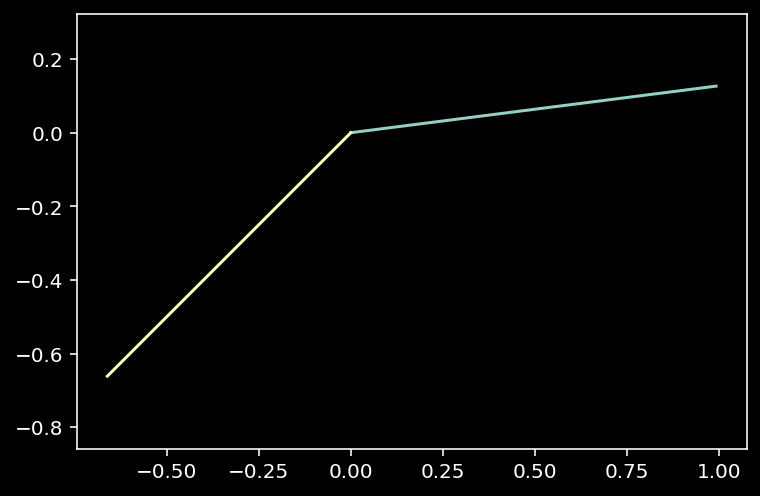

In [411]:
fig, ax = plt.subplots()
ax.plot([0, kref[0]], [0, kref[1]])
ax.plot([0, -kinc[1]], [0, -kinc[1]])
ax.axis('equal')
plt.show()

In [344]:
# dim = 500
# nxy = 1.5 * np.ones((dim, dim))
# Efield = np.zeros((3, dim, dim))
# Efield[0] = 1
# Efield[1] = 0
# Efield[2] = 0
# kinc = np.array([0,0,1])
# Hfield = np.cross(kinc, Efield, axis=0)

# # #EXH-Calc
# # calculate the Poynting vector
# Sfield = 0.5*np.real(np.cross(Efield, Hfield, axis=0))


# # #normIncidentk-Calc
# # calculate the magnitude of the Poynting field
# Sfieldmag = np.sqrt(np.sum(Sfield**2, axis=0))
# # calculate the transverse component of the Poynting vector
# Stransverse = np.sqrt(Sfield[0,:,:]**2 + Sfield[1,:,:]**2)
# # calculate the direction of the Poynting vector use that to estimate angles of incidence
# # here it's assumed that the normal is pointing in the +z direction
# # #β-Calc
# βfield = np.arctan2(Stransverse, Sfield[2, :, :])
# # #θ-Calc
# θfield = np.arcsin(nxy/nFree * np.sin(βfield))
# # calculate the unit vector in the direction of the Poynting vector
# kfield = Sfield / Sfieldmag
# numNans_k = np.sum(np.isnan(kfield))
# numNans_β = np.sum(np.isnan(βfield))
# numNans_θ = np.sum(np.isnan(θfield))
# print("kfield has {} NaNs".format(numNans_k))
# print("βfield has {} NaNs".format(numNans_β))
# print("θfield has {} NaNs".format(numNans_θ))

# # #FresnelS-Calc
# # #FresnelP-Calc
# # These I can calculate using the refractive indices and the angles of incidence
# # S is perpendicular to plane of incidence
# fresnelS = (2 * nxy * np.cos(βfield) 
#             / ( nxy * np.cos(βfield) 
#                + np.sqrt(nFree**2 
#                                - nxy**2 * np.sin(βfield)**2)
#                 )
#             )
# fresnelP = (2 * nFree * nxy * np.cos(βfield) 
#             / (nFree**2 * np.cos(βfield) 
#                +  nxy * np.sqrt(nFree**2 
#                           - nxy**2 * np.sin(βfield)**2)
#                 )
#             )


# # #ζ-Calc
# # calculate the unit vector field perpendicular to the plane of incidence
# # which is basically k X z
# ζfield = np.zeros(kfield.shape)
# ζfield[0] = kfield[1]
# ζfield[1] = -kfield[0]
# # normalize the ζfield
# ζfield /= np.sqrt(np.sum(np.abs(ζfield)**2, axis=0))
# # in the case of normal incidence, ζfield is undefined
# # so set it can be set to anything
# normalIncidence = (βfield == 0)
# ζfield[0][normalIncidence] = 1
# ζfield[1][normalIncidence] = 0
# ζfield[2][normalIncidence] = 0

# # decompose the field in P and S polarizations
# # first find P-pol and then use the complement to determine S-pol
# # the S-pol can be obtained by the dot product of E with ζ
# #EincS-Calc
# ESdot = Efield[0,:,:] * ζfield[0] + Efield[1,:,:] * ζfield[1]
# EincS = np.zeros(ζfield.shape)
# EincS[0] = ESdot[0] * ζfield[0]
# EincS[1] = ESdot[1] * ζfield[1]
# #EincP-Calc
# EincP = Efield - EincS
# del ESdot

# #ErefS-Calc
# ErefS = np.zeros(Efield.shape)
# ErefS[0] = fresnelS * EincS[0]
# ErefS[1] = fresnelS * EincS[1]
# ErefS[2] = fresnelS * EincS[2]

# #ErefP-Calc
# ErefP = np.zeros(Efield.shape)
# ErefP[0] = fresnelP * EincP[0]
# ErefP[1] = fresnelP * EincP[1]
# ErefP[2] = fresnelP * EincP[2]

# #Eref-Calc
# Eref  = ErefS + ErefP

# #kref-Calc
# ξfield    = np.zeros(ζfield.shape)
# ξfield[0] = -ζfield[1]
# ξfield[1] = ζfield[0]
# kref      = np.zeros(kfield.shape)
# kref[0]   = np.sin(θfield) * ξfield[0]
# kref[1]   = np.sin(θfield) * ξfield[1]
# kref[2]   = np.cos(θfield)

# #Href-Calc
# Href = nFree * np.cross(kref, Eref, axis=0)


kfield has 0 NaNs
βfield has 0 NaNs
θfield has 0 NaNs


In [345]:
Eref

array([[[1.2, 1.2, 1.2, ..., 1.2, 1.2, 1.2],
        [1.2, 1.2, 1.2, ..., 1.2, 1.2, 1.2],
        [1.2, 1.2, 1.2, ..., 1.2, 1.2, 1.2],
        ...,
        [1.2, 1.2, 1.2, ..., 1.2, 1.2, 1.2],
        [1.2, 1.2, 1.2, ..., 1.2, 1.2, 1.2],
        [1.2, 1.2, 1.2, ..., 1.2, 1.2, 1.2]],

       [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

       [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]]])

In [333]:
# ζfield = np.zeros(kfield.shape)
# ζfield[0] = kfield[1]
# ζfield[1] = -kfield[0]
# np.sqrt(np.sum(np.abs(ζfield)**2, axis=0))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [329]:
np.sum(np.isnan(ζfield))

750000

In [283]:
athing = np.random.random(kref.shape)
bthing = np.random.random(kref.shape)
cthing = np.cross(athing, bthing, axis=0)
(np.sum(~(cthing[0] == (athing[1]*bthing[2] - athing[2]*bthing[1]))),
np.sum(~(cthing[1] == (-athing[0]*bthing[2] + athing[2]*bthing[0]))),
np.sum(~(cthing[2] == (athing[0]*bthing[1] - athing[1]*bthing[0]))))

(0, 0, 0)

In [274]:
np.sum(~(Href[1] == (-kref[0]*Eref[2] + kref[2]*Eref[0])))

473

In [276]:
np.sum(np.isnan(kref))

1418

In [258]:
# indexpick = 80
# akinc = np.array([kfield[0,indexpick,indexpick], kfield[1,indexpick,indexpick], kfield[2,indexpick,indexpick]])
# aζinc = np.array([ζfield[0,indexpick,indexpick], ζfield[1,indexpick,indexpick], ζfield[2,indexpick,indexpick]])
# dot1 = np.dot(akinc, aζinc)
# akref = np.array([kref[0,indexpick,indexpick], kref[1,indexpick,indexpick], kref[2,indexpick,indexpick]])
# dot2 = np.dot(akref, aζinc)
# aθ = θfield[indexpick,indexpick]
# aβ = βfield[indexpick,indexpick]
# dot3 = np.dot(akinc, akref)
# (dot1, dot2, dot3 - np.cos(aθ-aβ))

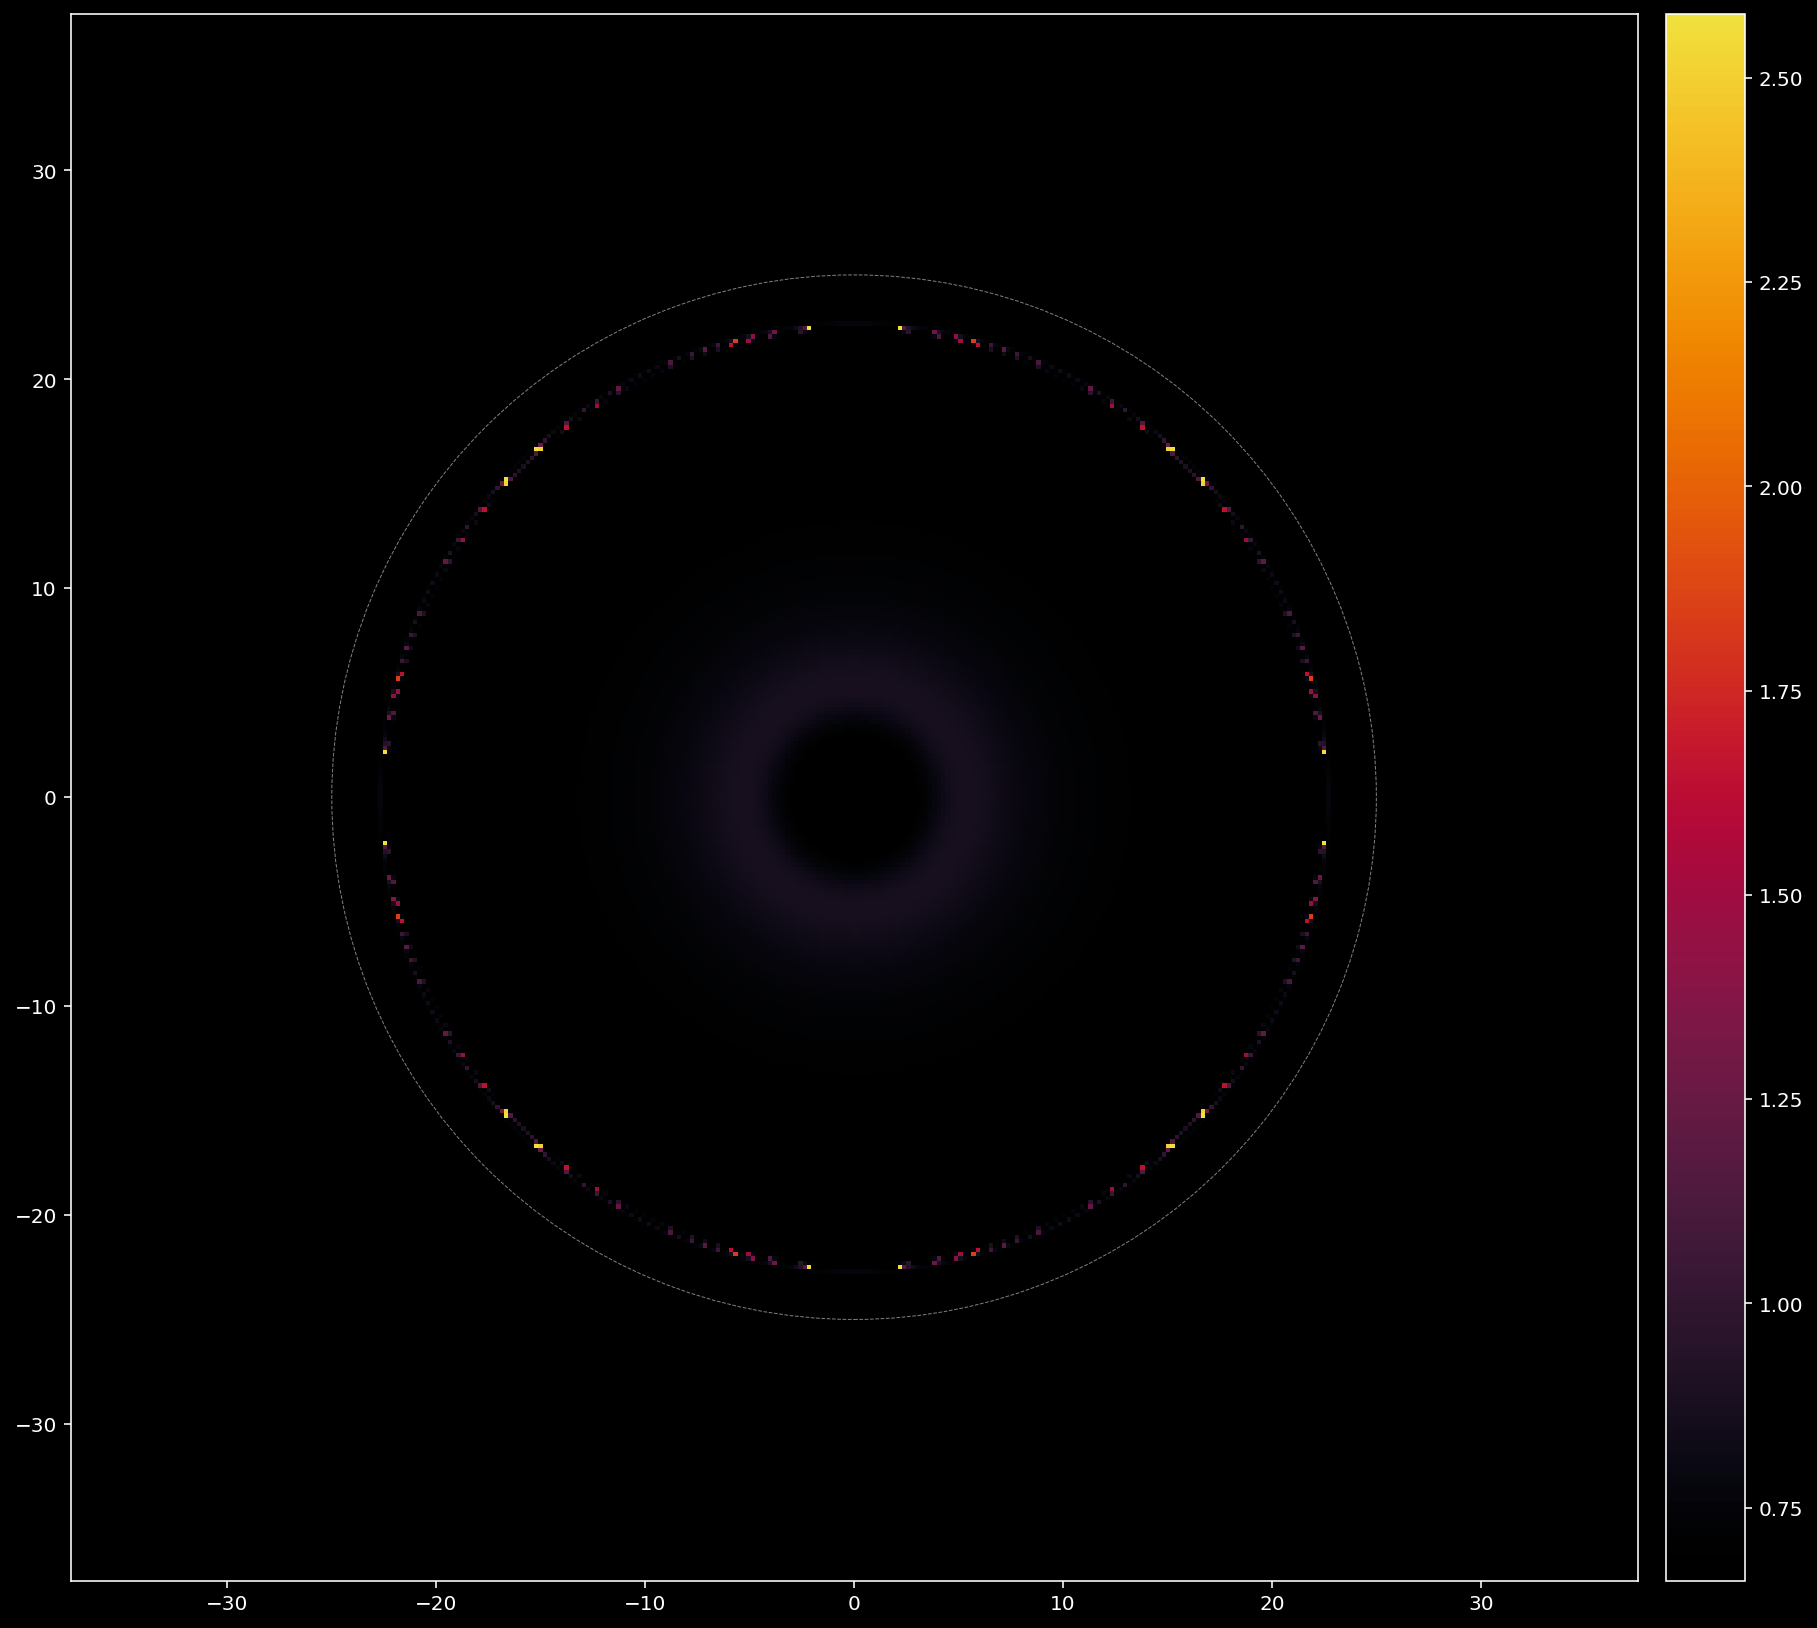

In [208]:
# using these I can also compute the local field of tranmission
transmissionS = np.real(fresnelS)**2 * (nFree**2/nCore**2)
transmissionP = np.real(fresnelP)**2 * (nFree**2/nCore**2)

fig, ax = plt.subplots(figsize=(15,15))
iplot = ax.imshow(transmissionP,
                cmap=cm.ember,
                extent=extent)
circle = Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5)
ax.add_patch(circle)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(iplot, cax=cax)#, format=ticker.FuncFormatter(fmt))
plt.show()

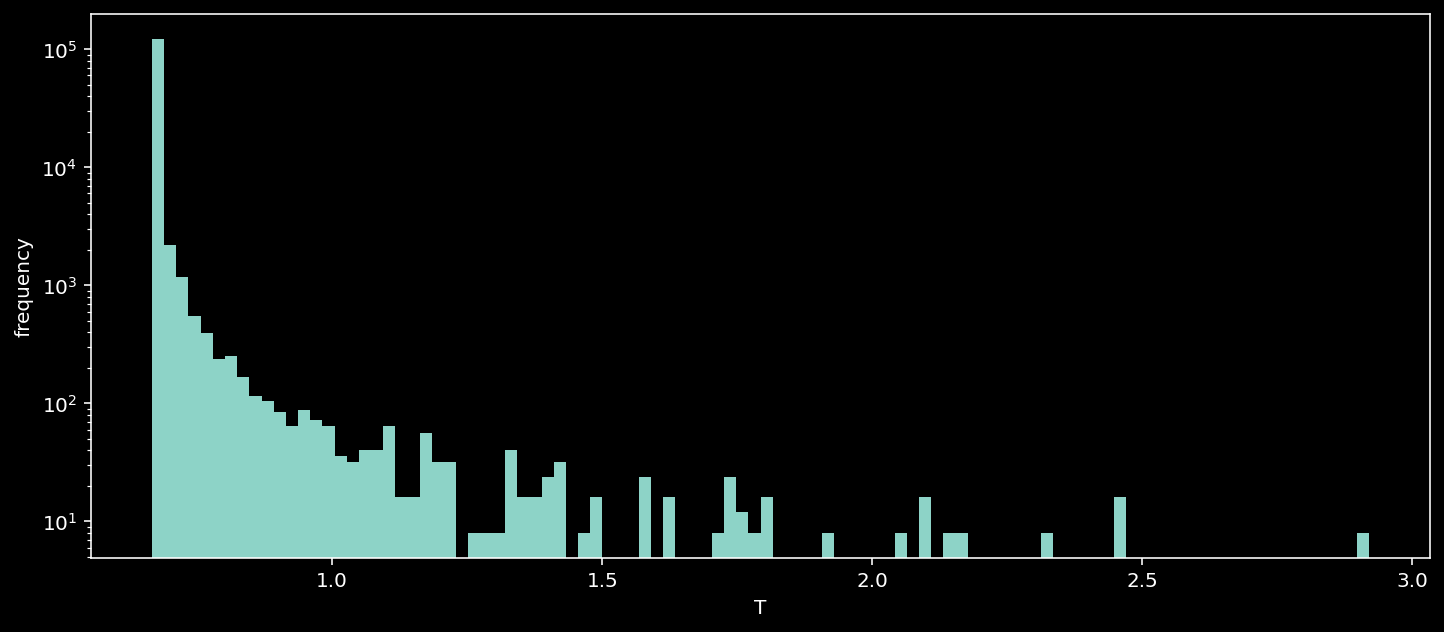

In [ ]:
plt.figure(figsize=(12, 5))
plt.hist(transmissionS.flatten(), bins=100)
plt.xlabel('T')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

In [ ]:
string = '''# Local-k approximation to refraction

Given a mode in the waveguide whose propagation is suddenly truncated by the end of the waveguide, find the fields right outside the fiber by using the direction of the Poynting vector as a local direction of propagation of the incident fields.

```

┌────────────────────────────────────────────────────────────────────────┐
│ ...................................................................... │
│ ...................................................................... │
│ ...............................┌──────┐............................... │
│ ...............................│E', H'│............................... │
│ ...............................└──────┘....................      ..... │
│ ...........................................................  nr  ..... │
│ ...........................................................      ..... │
│ XXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXX │
│ XXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------XXXXXXXXXXXXXXXX        XXXX │
│ XXXXXXXXXXXXXXXXXXXXXXXXXXXX----┌────┐----XXXXXXXXXXXXXXXX n(x,y) XXXX │
│ XXXXXXXXXXXXXXXXXXXXXXXXXXXX----│E, H│----XXXXXXXXXXXXXXXX        XXXX │
│ XXXXXXXXXXXXXXXXXXXXXXXXXXXX----└────┘----XXXXXXXXXXXXXXXXXXXXXXXXXXXX │
│ XXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXX │
│ XXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXX │
│ XXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXX │
│                                                                        │
│                                   │                                    │
│                                                                        │
│                                   │                                    │
│                                                                        │
│                                   ├┐                      ┌────        │
│                                    └─┐  θ            ┌────┘            │
│                                   │  └─┐        ┌────┘                 │
│                                        └─┐ ┌────┘                      │
│                                   │  ┌───┴─┘                  nr       │
│       ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ┬────┘─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─      │
│                               ┌─┘ │                        n(x,y)      │
│                             ┌─┘                                        │
│                           ┌┬┘     │                                    │
│                         ┌─┘└─┐                                         │
│                       ┌─┘    └─┐  │                                    │
│                     ┌─┘     β  └─┐                                     │
│                   ┌─┘            └┤                                    │
│                 ┌─┘                                                    │
│                ─┘                 │                                    │
│                                                                        │
└────────────────────────────────────────────────────────────────────────┘

```


```mermaid
flowchart TB

Start["Given:
k_z : propagation constant of mode
Δλ  : sampling resolution of arrays
a   : the radius of the waveguide core
b   : side of computational square
nCore : ref index of core
nCladding : ref index of cladding
nFree : ref index of launching space"]

Start --> indexArray["[#nxy-Calc]
Calculate n(x,y) on a plane
transverse to the waveguide."]

Start --> AeAhBeBh["[#AB-Calc]
Calculate the coefficients
Ae, Ah, Be, Bh over the core and cladding
regions for the related mode."]

AeAhBeBh --> Field["[#EH-Calc]
Calculate the numerical
values of the mode over
a grid with resolution Δλ.
E(x,y) = (E_z, <b>E<b/>_T)
H(x,y) = (H_z, <b>H<b/>_T)"]

Field -->  Poynting["[#EXH-Calc]
Poynting Vector Field
<b>P</b>(x,y) = ½ Re(<b>E</b> x <b>H</b>*)"]

Poynting --> localk["[#normIncidentk-Calc]
Normalized incident k <br>k̂ := <b>k</b>/|k| ≈ <b>P</b>/|P|"]

localk --> Incident["[#β-Calc]
Angle of incidence across interface
β(x,y)"]

Incident & indexArray -->  Refracted["[#θ-Calc]
Angles of refraction across interface
θ(x,y)"]

Incident & Field --> FresnelS["[#FresnelS-Calc]
Fresnel-S Coefficient
FS(x,y) = E_S'/E_S (S-pol)"]

Incident & Field --> FresnelP["[#FresnelP-Calc]
    Fresnel-P Coefficient<br>FP(x,y) = E_P'/E_P (P-pol)"]

localk --> Sdir["[#ζ-Calc]
    S-Normal vector field
    (Direction normal to plane of incidence)
    <b>ζ(x,y)<b/> = ẑ x k̂
    ζ̂(x,y) = <b>ζ<b/> / |ζ|"]

Sdir --> Spol["[#EincS-Calc]
S-component of E
E_S = <b>E</b> · ζ̂"]

Spol --> Ppol["[#EincP-Calc]
P-component of E
E_P = E - E_S"]

Ppol & FresnelP --> EPref["[#ErefP-Calc]
Refracted E (P-pol)
E_P' = E_P  FP(x,y)"]

Spol & FresnelS --> ESref["[#ErefS-Calc]
Refracted E (S-pol)
E_S' = E_S  FS(x,y)"]

EPref & ESref --> Eref["[#Eref-Calc]
The refracted electric field
E' = E_S + E_P"]

indexArray & localk --> localkrefnorm["[#kref-Calc]
Normalized refracted k̂' 
<b>k̂'</b>"]

localkrefnorm & Eref --> Href["[#Href-Calc]
The refracted H-field<br>H' ≈ √(μ'ϵ')/µ' k̂' x E'"]

style Start fill:blue
style Href fill:red
style Eref fill:red
```
'''

In [ ]:
# import re

# def extract_substrings_inside_square_brackets(text):
#     pattern = r'\[#([^]]+)\]'
#     substrings = re.findall(pattern, text)
#     return substrings

# hashes = extract_substrings_inside_square_brackets(string)
# for idx, hash in enumerate(hashes):
#     print(f'{hash}')

In [ ]:
'''
nxy-Calc
AB-Calc
EH-Calc
EXH-Calc
normIncidentk-Calc
β-Calc
θ-Calc
FresnelS-Calc
FresnelP-Calc
ζ-Calc
EincS-Calc
EincP-Calc
ErefP-Calc
ErefS-Calc
Eref-Calc
kref-Calc
Href-Calc
'''

#### ####Spaguetti code

In [ ]:
# given a field (Ex, Ey, Ez) at a plane calculate the discrete
# fourier transform of the field in the x,y,z directions
# this would provide the field in the frequency domain
# the field is assumed to be periodic in the x,y,z directions
fiberfield_t = np.copy(eigenbasis[0,0,:,:,:])
# at the moment I haven't calculate the z component of the field
# let me just assume a z component that is roughly of the same magnitude 
# of the x and y components, that starts normal at the center and
# deviates to the NA of the fiber at the edge of it

In [ ]:
Ex = fiberfield_t[0,:,:]
Ey = fiberfield_t[1,:,:]
NA = fiber_sol['NA']
nCore = fiber_sol['nCore']
a = fiber_sol['coreRadius']
thetamax = np.arcsin(NA/nCore)
# calculate the magnitude of the transverse field
r = np.sqrt(Xg**2+Yg**2)
# calculate the angle of E at each point
launchAngle = thetamax/a * r
# knowing the angle at each position I should be able to "calculate"
# the z component of the field
# this doesn't make any sense, the direction of the
# electric field is not the direction of the wave vector
# ok, instead let me estimate the direction of the wave vector
# across the fiber and then use that together with the field at 
# each position to determine what is a compatible value for the z component
kmag = 2*np.pi/λfree*nCore
dirfield = np.arctan2(Yg, Xg)
xhat = np.cos(dirfield)
yhat = np.sin(dirfield)
kz = kmag * np.cos(launchAngle)
kx = kmag * np.sin(launchAngle) * xhat
ky = kmag * np.sin(launchAngle) * yhat
# at every point 
# now let me make
# use this to calculate a possible z component for E
dotEk = fiberfield_t[0,:,:] * kx + fiberfield_t[1,:,:] * ky
Ez = -dotEk/kz
# in this construction the electric field is always in parallel to the plane of incidence
fresnel = (2 * nCore * 1 * np.cos(launchAngle)
           / (1 * np.cos(launchAngle) + nCore * np.sqrt(1-nCore**2*np.sin(launchAngle)**2)))
Erefracted_x = fresnel * Ex
Erefracted_y = fresnel * Ey
Erefracted_z = fresnel * Ez

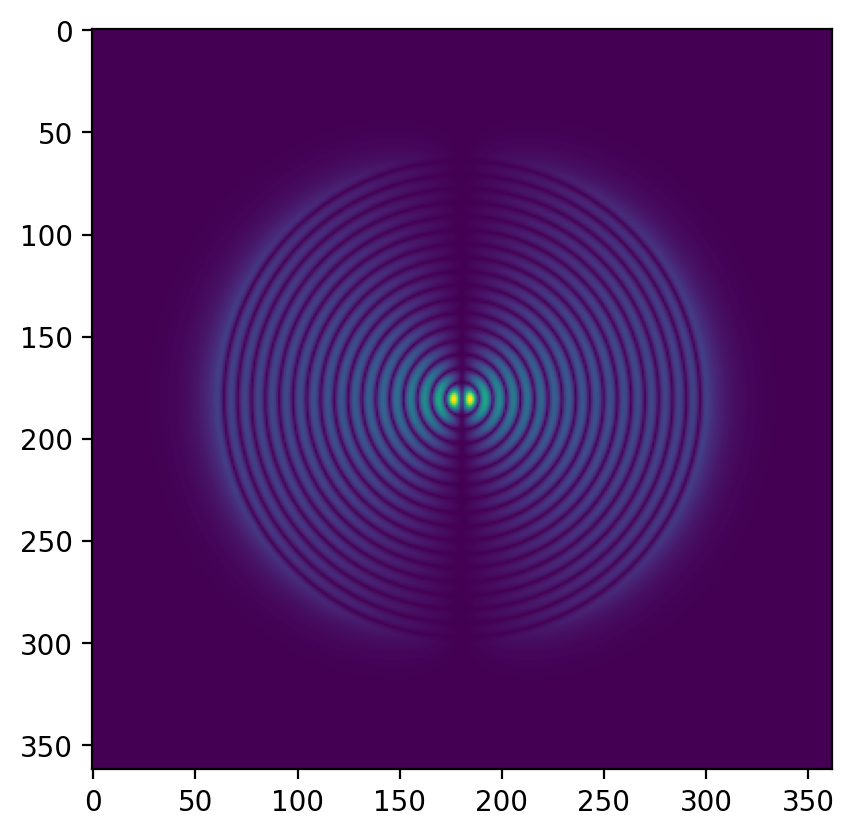

In [ ]:
plt.figure()
plt.imshow(np.abs(Erefracted_x))
plt.show()

In [ ]:
# ok, next part
# i need to find the farfield for the refracted field
# i think I have
apertureRadius = b
λ = λfree
k = 2 * np.pi / λ
replicas = 1
dist_to_ML = 20
zmax = dist_to_ML * 5
farfield_axis = np.linspace(0,zmax,100)
L = 2 * apertureRadius # spatial extent of the field
field = Erefracted_x
dx = L / field.shape[0]
idx_width = field.shape[0]
if replicas != 1:
    nearfourier.shape = np.pad(field,(idx_width, idx_width))
else:
    F = field
kx = 2 * np.pi * (np.fft.fftfreq(F.shape[0], d=dx))
ky = kx
kx, ky = np.meshgrid(kx, ky)
kz = np.sqrt(k**2 - kx**2 - ky**2 + 0j)

gator = 1.j * np.outer(farfield_axis, kz)
gator = gator.reshape((*farfield_axis.shape, *kz.shape))
gator = np.exp(gator)


In [ ]:
np.arcsin(NA)/np.pi*180

12.709032994395436

In [ ]:
gator.shape

(100, 362, 362)

In [ ]:
import cmasher as cmr

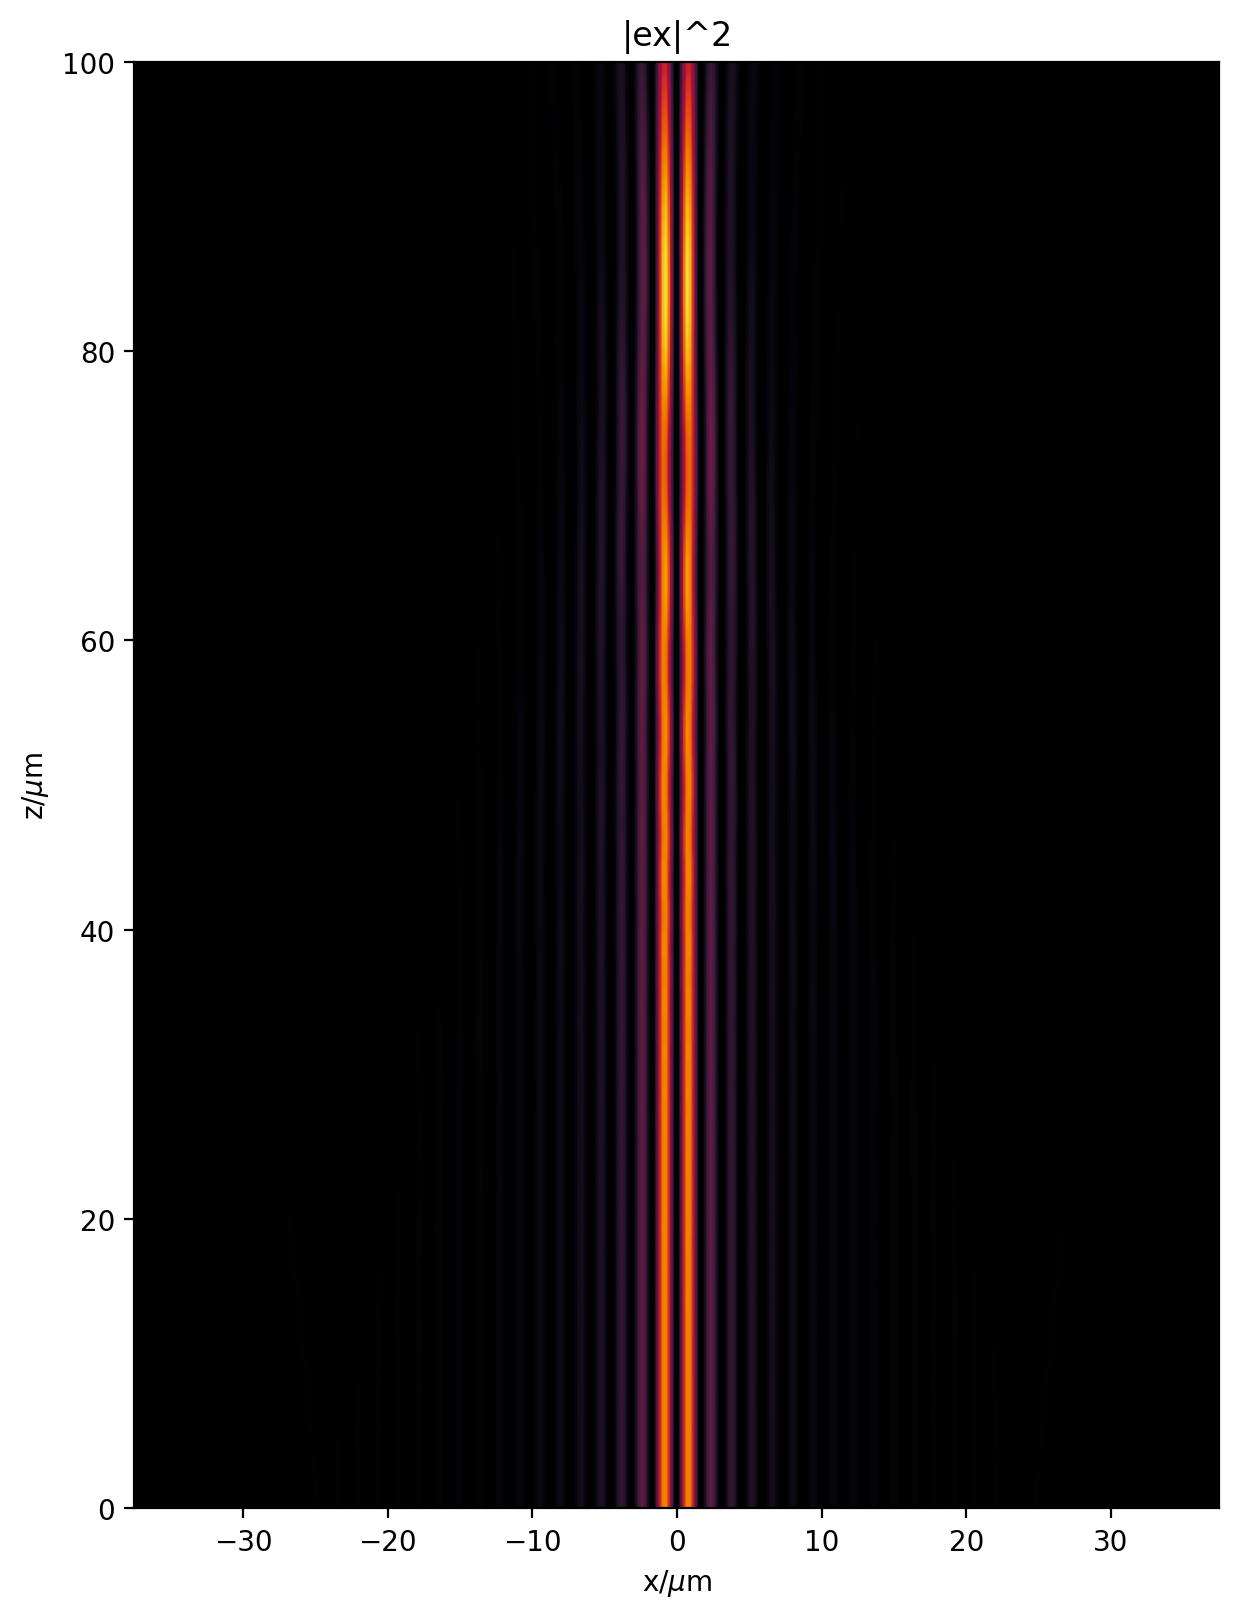

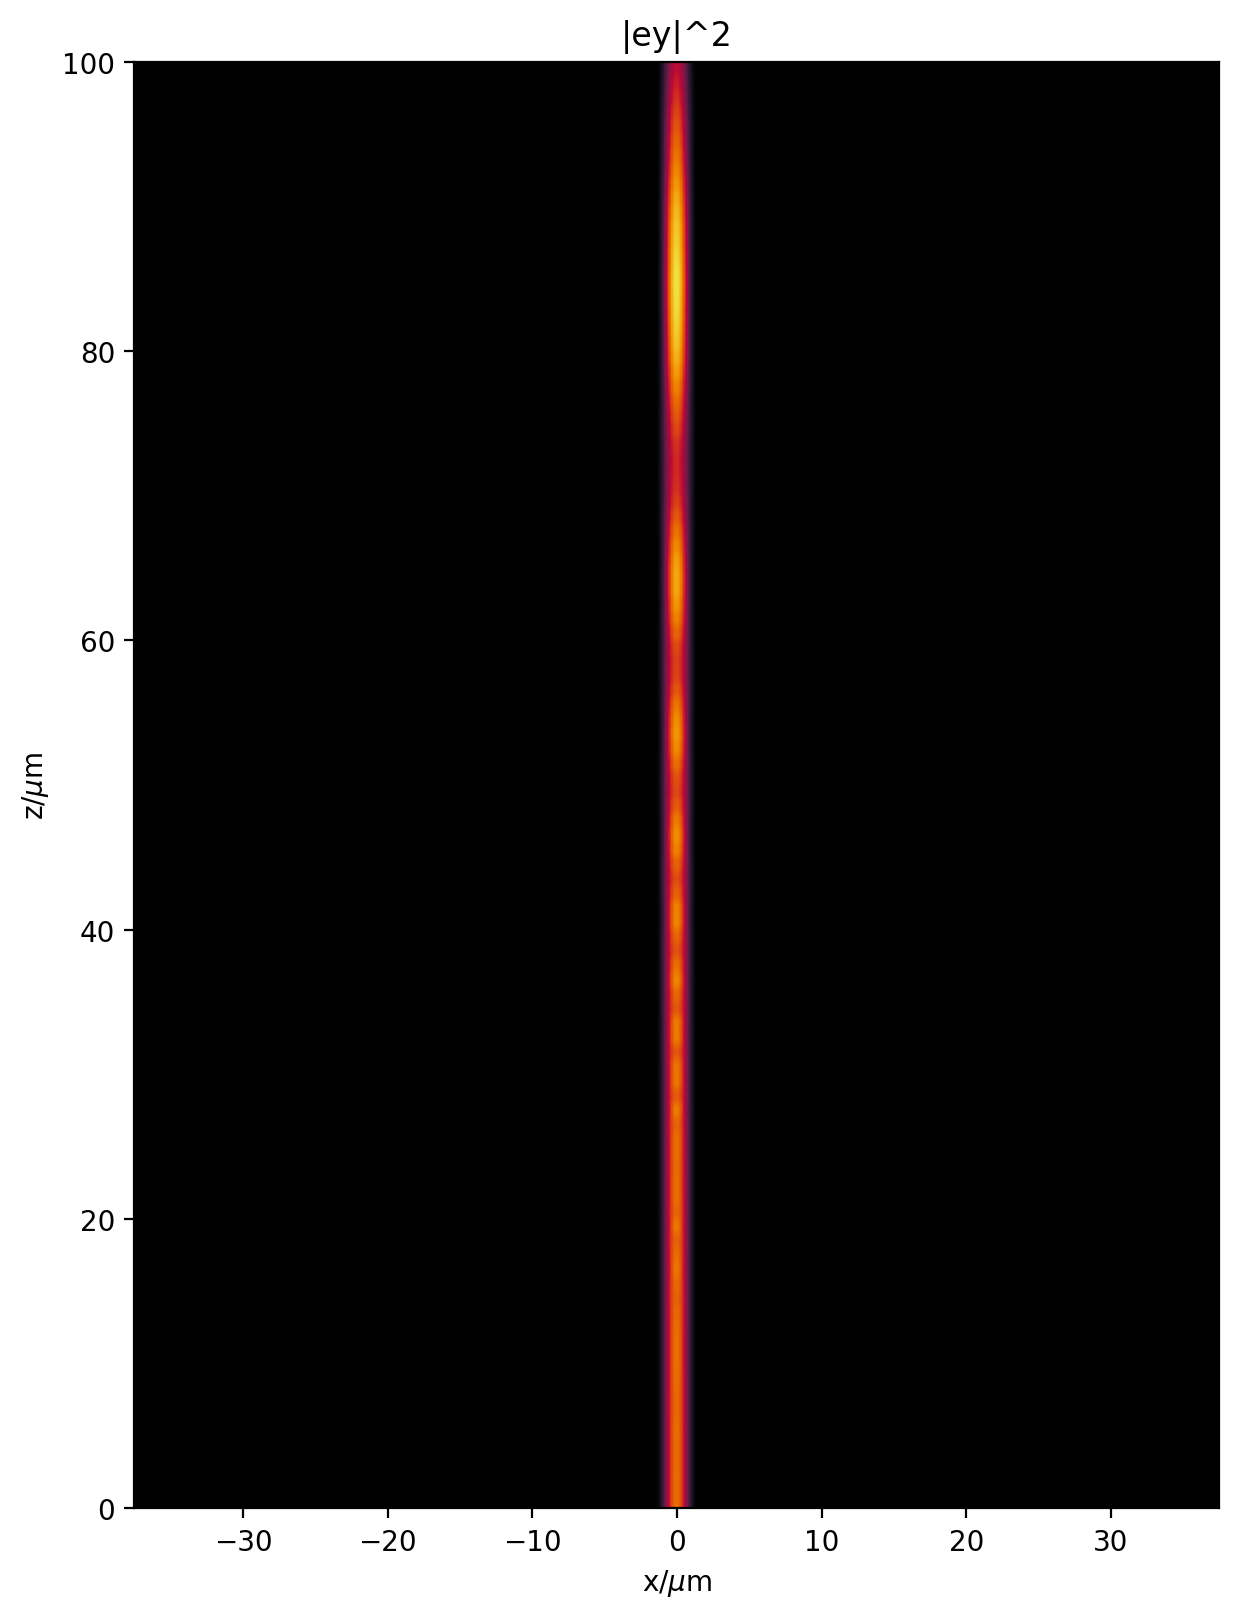

In [ ]:
farfields = {}
fields = {'ex':Erefracted_x, 'ey':Erefracted_y}
for field_component in ['ex','ey']:
    field = fields[field_component]
    dx = L / field.shape[0]
    idx_width = field.shape[0]
    F = field
    # calculate the Fourier transform of the nearfield
    nearfourier = np.fft.fft2(F)
    # multiply by the farfield propagator
    farfourier = nearfourier * gator
    # calculate the inverse Fourier transform
    farfield = np.fft.ifft2(farfourier)

    extent = [-L/2 * replicas, L/2 * replicas, 0, zmax]
    # get the field on the zx plane
    pfield = np.abs(farfield[::,farfield.shape[-2]//2])**2
    farfields[field_component] = pfield

    plt.figure(figsize=(7,10))
    plt.imshow(pfield,
            cmap = cmr.ember,
            extent = extent,
            origin='lower')
    plt.xlim(-L/2, L/2)
    plt.xlabel('x/$\mu$m')
    plt.ylabel('z/$\mu$m')
    plt.title('|%s|^2' % field_component)
#     plt.colorbar()
    plt.show()

## ##Gray Notation (deprecated)

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:19: RuntimeWarning: invalid value encountered in sqrt
  return  (n1**2*(special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))))/(2.*a*n0**2*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) - special.kn(1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)*special.kn(n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))


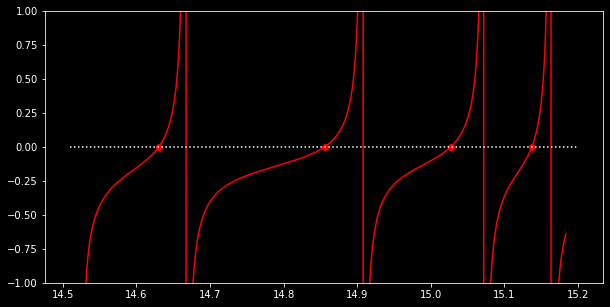

In [ ]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
tmfun = ws.tmfungen(λfree=wavelength, 
                 n=0, 
                 n0=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
γmax = 1.001*nCore*2*np.pi/wavelength
γmin = 0.999*nCladding*2*np.pi/wavelength
γrange = np.linspace(γmin, γmax, 1000)
tmvals = tmfun(γrange)
tmzeros = ws.findallroots(tmfun, γmin, γmax, 0.01, method='bisect', num_decimals=6, verbose=False)
tmzerocheck = tmfun(tmzeros)
plt.figure(figsize=(10,5))
plt.plot(γrange, tmvals, 'r')
plt.scatter(tmzeros,tmzerocheck, c='r')
plt.plot([γmin, γmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:25: RuntimeWarning: invalid value encountered in sqrt
  return (special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) - special.kn(1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)*special.kn(n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))


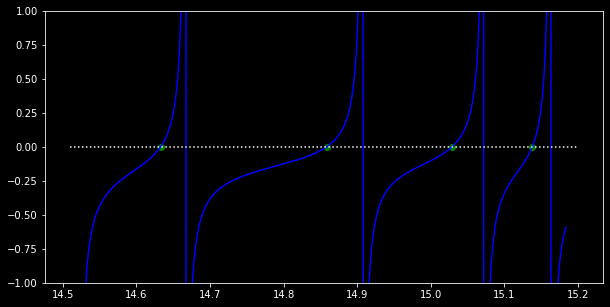

In [ ]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
tefun = ws.tefungen(λfree=wavelength, 
                 n=0, 
                 n0=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
γmax = 1.001*nCore*2*np.pi/wavelength
γmin = 0.999*nCladding*2*np.pi/wavelength
γrange = np.linspace(γmin, γmax, 1000)
tevals = tefun(γrange)
tezeros = ws.findallroots(tefun, γmin, γmax, 0.01, method='bisect', num_decimals=6)
tezerocheck = tefun(tezeros)
plt.figure(figsize=(10,5))
plt.plot(γrange, tevals, 'b')
plt.scatter(tezeros,tezerocheck, c='g')
plt.plot([γmin, γmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:30: RuntimeWarning: invalid value encountered in sqrt
  return  -((n**2*(1/(γ**2 - (4*n0**2*np.pi**2)/λfree**2) + 1/(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))*(1/(a**2*(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) + n1**2/(a**2*n0**2*(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))))/a**2) + ((special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) - special.kn(1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)*special.kn(n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2))))*((n1**2*(special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))))/(2.*a*n0**2*np.sqrt(-γ**2 + (4*n1**2*

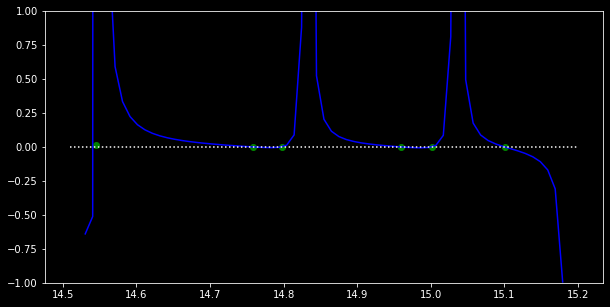

In [ ]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
n=3
hefun = ws.hefungen(λfree=wavelength, 
                 n=n, 
                 n0=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
γmax = 1.001*nCore*2*np.pi/wavelength
γmin = 0.999*nCladding*2*np.pi/wavelength
# γrange = np.linspace(γmin, γmax, 1000)
dx = 0.01
γrange = np.linspace(γmin, γmax, int(np.ceil((γmax-γmin)/dx)))
hevals = hefun(γrange)
zc = ws.zerocrossings(hevals)
zcvals = hevals[zc]
good_crossings = np.where(~np.isnan(zcvals))
zcvals = zcvals[good_crossings]
zc = zc[good_crossings]
hezeros = ws.findallroots(hefun, γmin, γmax, dx, method='bisect', num_decimals=6, verbose=False)
hezerocheck = hefun(hezeros)
plt.figure(figsize=(10,5))
plt.plot(γrange, hevals, 'b')
plt.scatter(hezeros,hezerocheck, c='g')
plt.plot([γmin, γmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()